# GPU Configuration

In [1]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


In [17]:
'''
tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Run on the GPU
c = tf.matmul(a, b)
print(c)
'''

"\ntf.debugging.set_log_device_placement(True)\n\n# Place tensors on the CPU\nwith tf.device('/GPU:0'):\n  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])\n  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])\n\n# Run on the GPU\nc = tf.matmul(a, b)\nprint(c)\n"

In [18]:
# tf.debugging.set_log_device_placement(False)

In [19]:
# tf.test.is_gpu_available()

# Data Pipeline

1. Load data from file into tf.data.Dataset
2. EDA on data
3. Prepare dataset using data from first UE
4. Shuffle the dataset
5. Split dataset into train, test and validation sets
6. Batch the training and validation dataset
7. Create custom callbacks for validation and evaluation
8. For each batched training dataset,
    - Preprocess data by converting to heatmaps
    - Train the model with the batched dataset
9. Diagnosis

## 1. Load data from file into tf.data.Dataset

In [2]:
# may delete later
# New way to import the data
import h5py
import numpy as np
import tensorflow as tf

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

print(features.shape)
print(labels.shape)

def flatten_dataset(ds):
  
    prev_shape = ds.shape
    ds = ds.reshape(prev_shape[0]*prev_shape[1], prev_shape[2], prev_shape[3])
    print(f'Reformatted shape is {ds.shape}')
    return ds

features = flatten_dataset(features)

count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])
labels = np.repeat(labels,4, axis=0)
# labels = tf.one_hot(labels, 3876)

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
# Would want to flatten the 4D np features array to a 3D np features array where (3876,4,16,193) --> (3876*4,16,193)
print(features.shape)
print(labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

print(dataset)

(3876, 4, 16, 193)
(3876, 3)
Reformatted shape is (15504, 16, 193)
(15504, 16, 193)
(15504,)
<MapDataset element_spec=(TensorSpec(shape=(16, 193), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


2023-06-12 07:14:03.267752: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 07:14:03.734710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25091 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:c1:00.0, compute capability: 8.6


## 2. EDA on data

## EDA to be performed

- Boxplot for ranges of x,y and z values
- Generate heatmap images for the same RP, from the different UEs and observe similarity
- Generate heatmap images for different RPs, from the same UEs and observe similarity

Note: Metrics used for similarity would be Structural Similarity Index Measure (SSIM).

<Figure size 3600x3600 with 0 Axes>

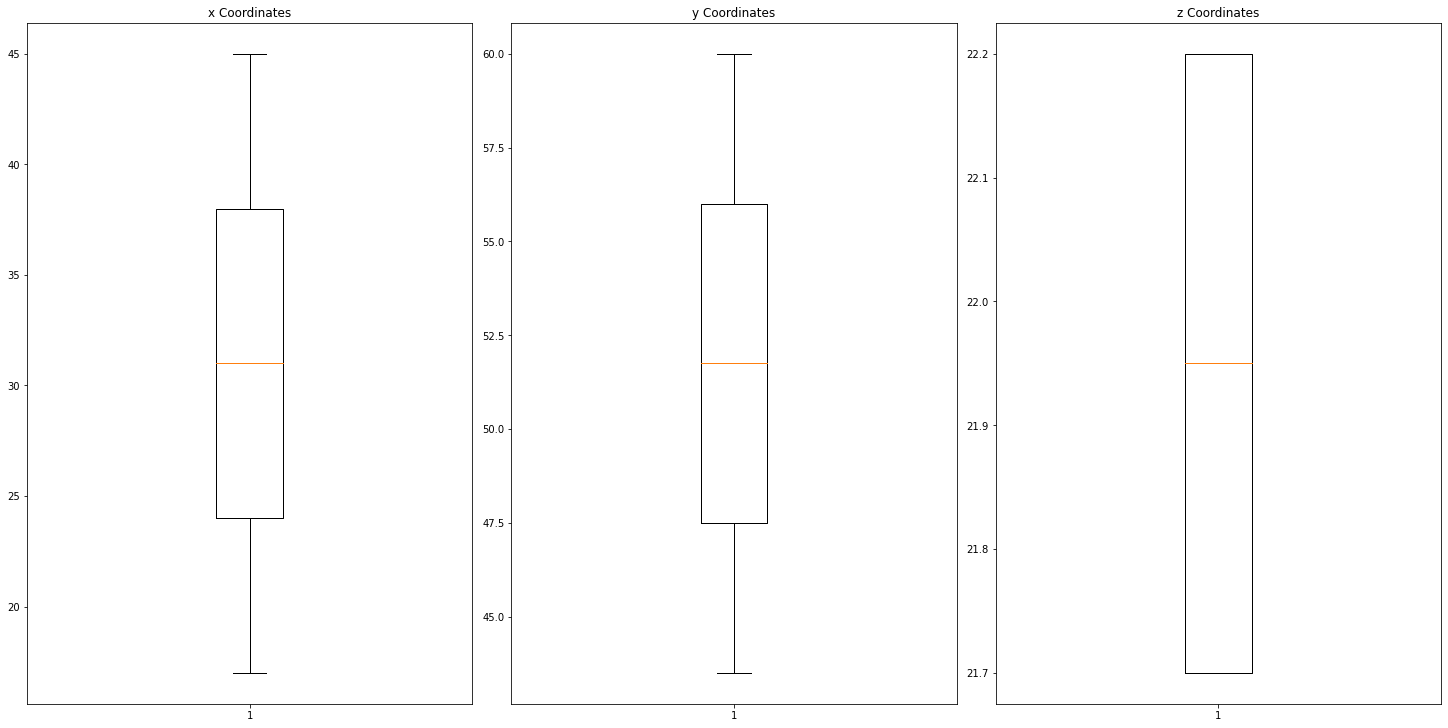

<Figure size 3600x3600 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3, constrained_layout = True)

# Get the distribution for x, y and z coordinates
coords = list(rp_dict.values())
coords = np.array(coords)

x_coords = coords[:,0]
y_coords = coords[:,1]
z_coords = coords[:,2]


axs[0].set_title('x Coordinates')
axs[0].boxplot(x_coords)
axs[1].set_title('y Coordinates')
axs[1].boxplot(y_coords)
axs[2].set_title('z Coordinates')
axs[2].boxplot(z_coords)


plt.figure(figsize = (50,50))

- x coordinates IQR(Q3 - Q1) of ~13.5m
- y coordinates IQR(Q3 - Q1) of ~ 8.5m
- z coordinates IQR(Q3 - Q1) of ~ 0.5m

In [6]:
# Function to generate heatmaps, not the same as function below used to get heatmap pixel values from heatmap
def get_features(feature):
        
    for f, l in feature:
        
        f = f.numpy()
        f = f.T

        return f

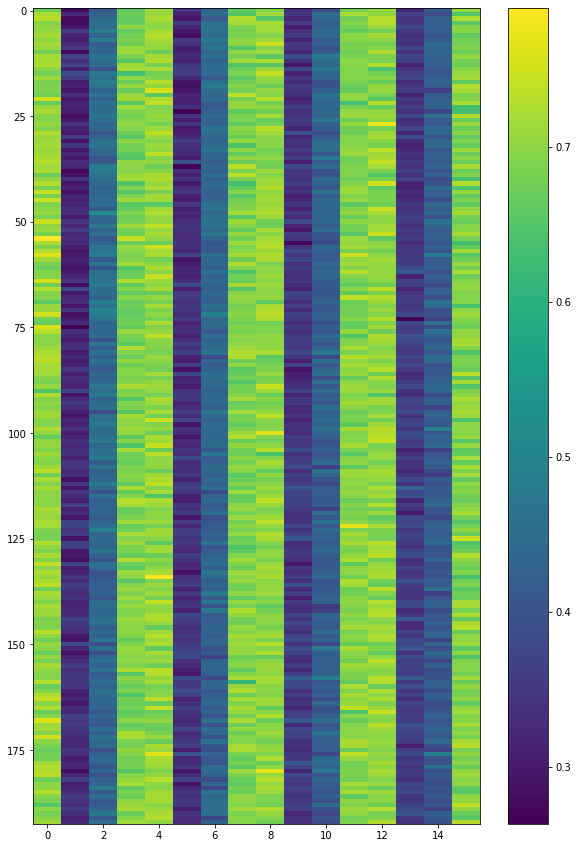

In [10]:
plt.rcParams['figure.figsize'] = [10, 15]

feature_1 = get_features(dataset.take(1))

plt.colorbar(plt.imshow(feature_1))
plt.imshow(feature_1, aspect = 'auto')

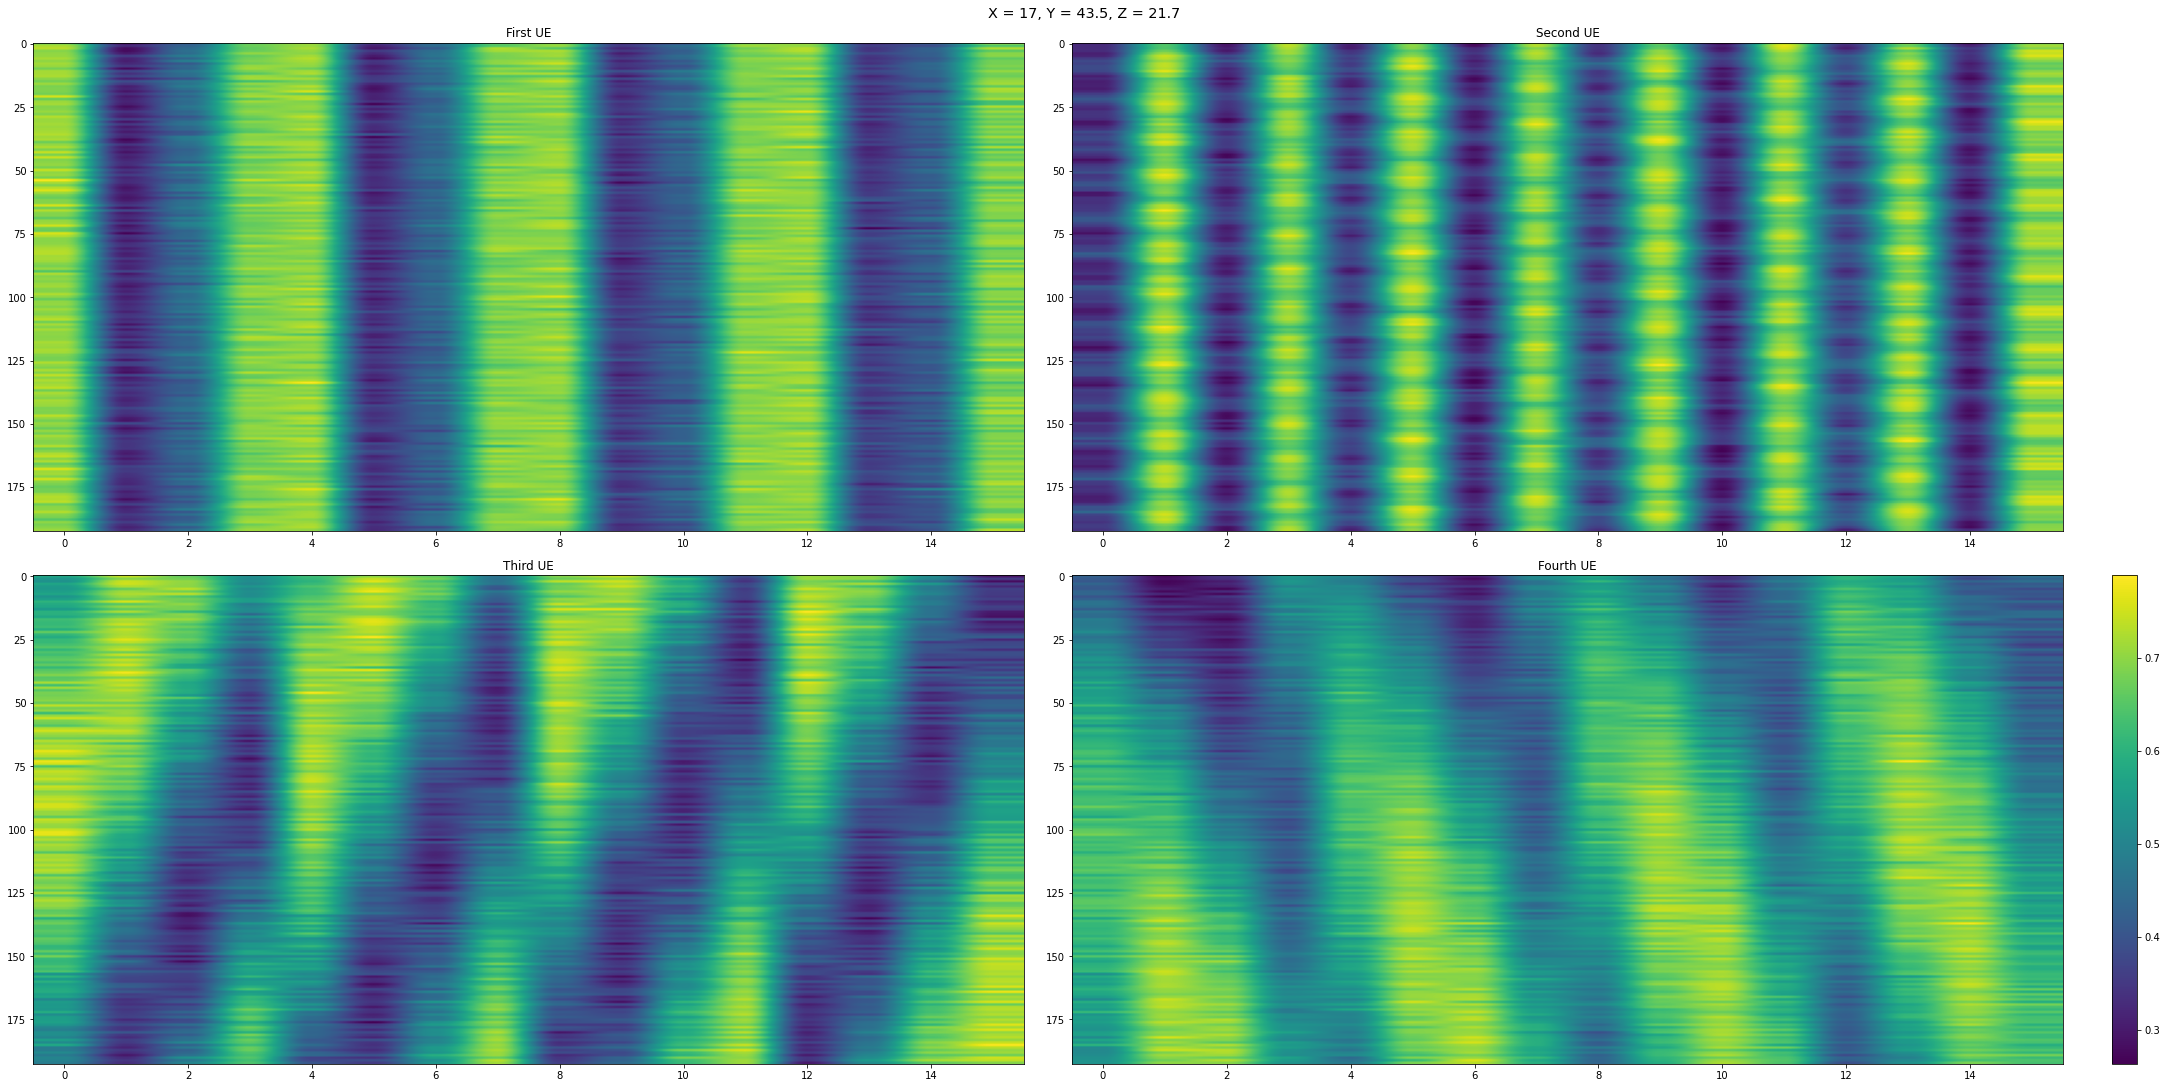

In [235]:
# Part 1 - Generate heatmap images for the same RP, from the different UEs and observe similarity
# Let's take the heatmap images from the four UEs, from the first reference point (17. , 43.5 , 21.7)

feature_1 = get_features(dataset.take(1))
feature_2 = get_features(dataset.skip(1).take(1))
feature_3 = get_features(dataset.skip(2).take(1))
feature_4 = get_features(dataset.skip(3).take(1))

fig, axs = plt.subplots(2,2, constrained_layout = True)

# Overall title
fig.suptitle("X = 17, Y = 43.5, Z = 21.7", fontsize="x-large")

plt.colorbar(plt.imshow(feature_1))
axs[0,0].imshow(feature_1, aspect = 'auto')
axs[0,0].title.set_text("First UE")
axs[0,1].imshow(feature_2, aspect = 'auto')
axs[0,1].title.set_text("Second UE")
axs[1,0].imshow(feature_3, aspect = 'auto')
axs[1,0].title.set_text("Third UE")
axs[1,1].imshow(feature_4, aspect = 'auto')
axs[1,1].title.set_text("Fourth UE")

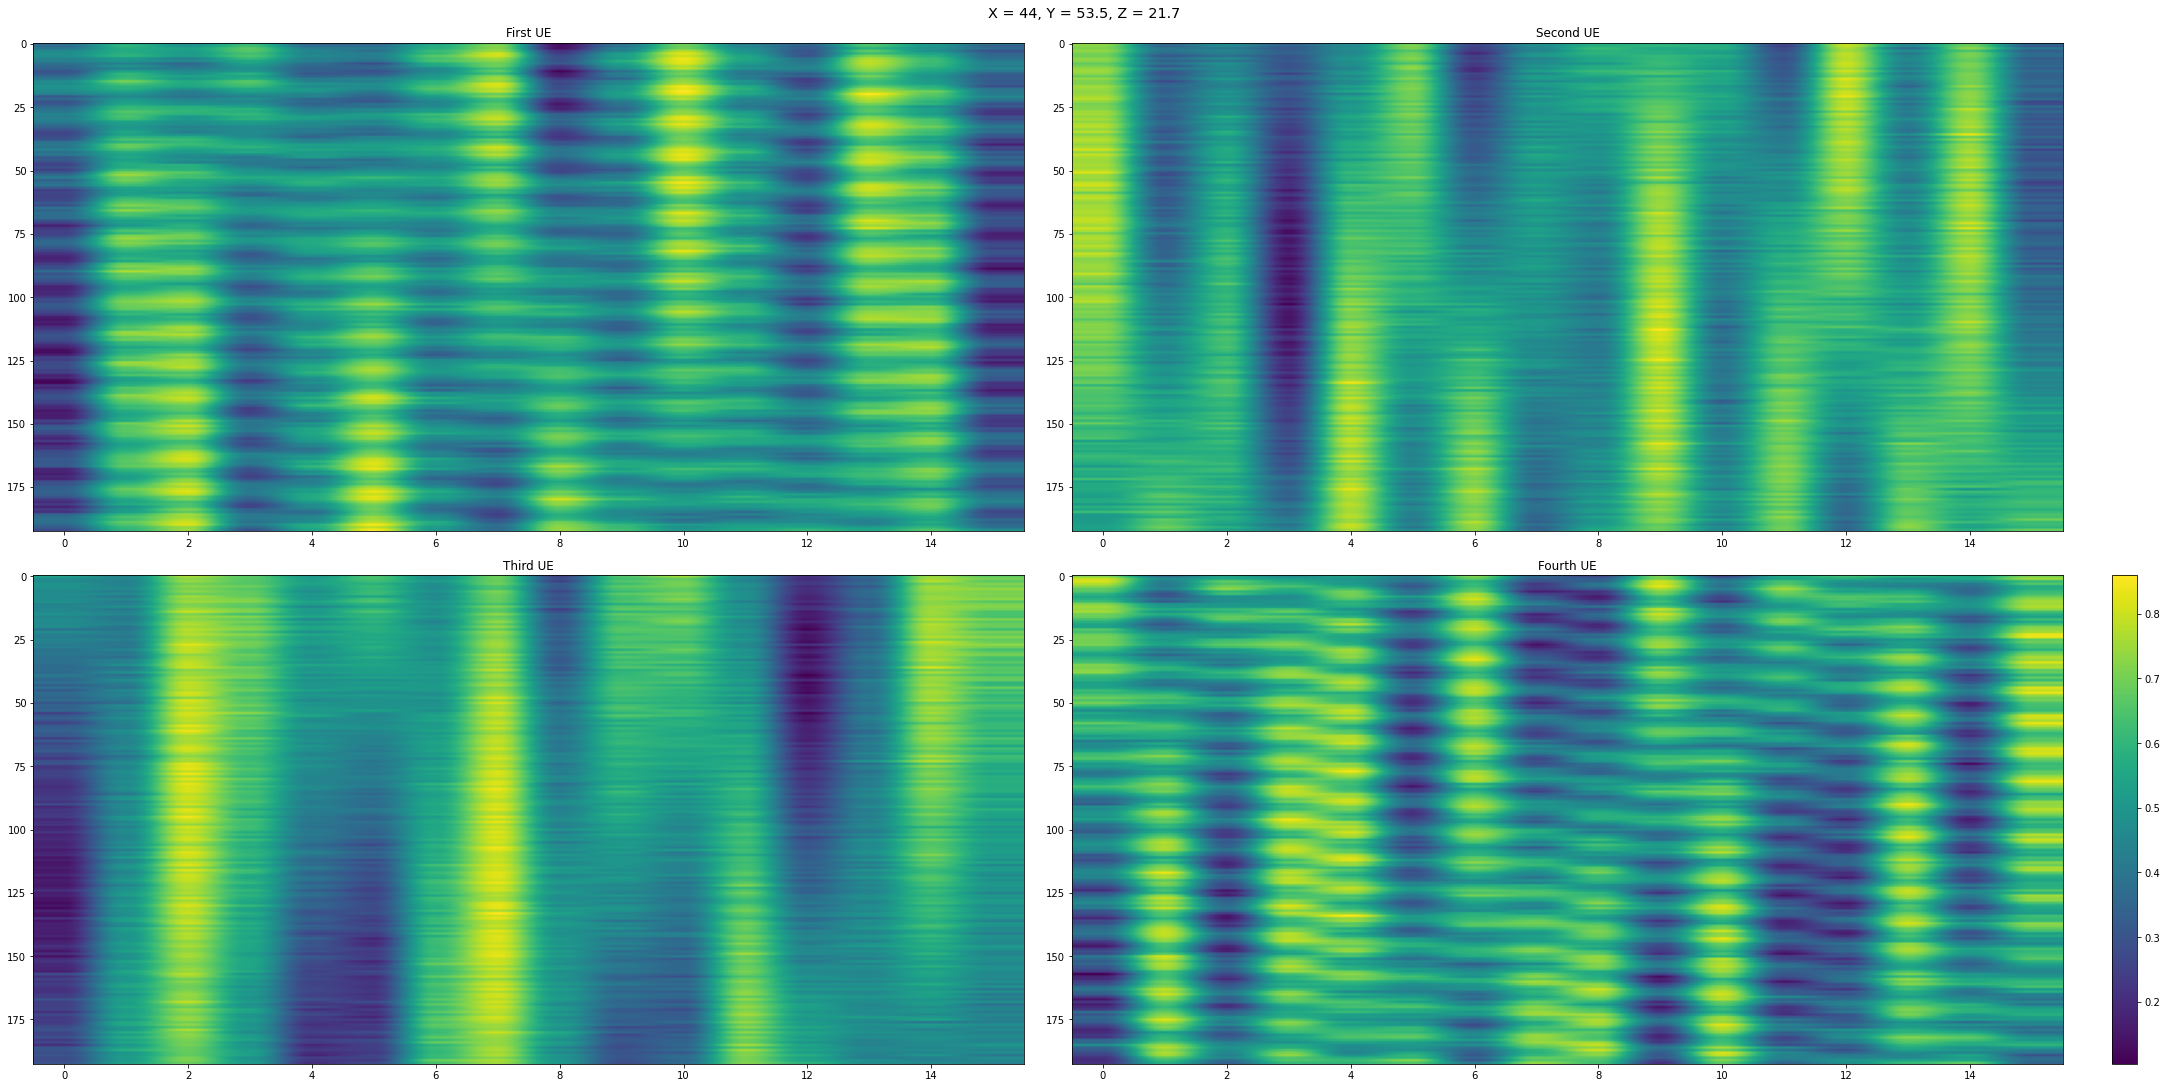

In [236]:
feature_1 = get_features(dataset.skip(7423).take(1))
feature_2 = get_features(dataset.skip(7424).take(1))
feature_3 = get_features(dataset.skip(7425).take(1))
feature_4 = get_features(dataset.skip(7426).take(1))

fig, axs = plt.subplots(2,2, constrained_layout = True)

# Overall title
fig.suptitle("X = 44, Y = 53.5, Z = 21.7", fontsize="x-large")

plt.colorbar(plt.imshow(feature_1))
axs[0,0].imshow(feature_1, aspect = 'auto')
axs[0,0].title.set_text("First UE")
axs[0,1].imshow(feature_2, aspect = 'auto')
axs[0,1].title.set_text("Second UE")
axs[1,0].imshow(feature_3, aspect = 'auto')
axs[1,0].title.set_text("Third UE")
axs[1,1].imshow(feature_4, aspect = 'auto')
axs[1,1].title.set_text("Fourth UE")

- Observation: For similar coordinates, heatmaps are distinctively different.
- Conclusion: Fingerprints obtained from the different UEs should not be treated as inputs for the same coordinates.2907

Moving forward, let's use the SSIM metrics to determine how different the images are where value of 1 implies that images are similar/same while value of -1 implies that images are very different.

In [237]:
# Lets compare heatmap from first UE to the other UE's heatmap images
def ssim_generate_heatmap(feature):

    im = plt.imshow(feature)
    plt.close() # for preventing heatmap from showing
    plt.clf() # clear current figure when done

    colour_vals_rgba = im.cmap(im.norm(im.get_array()))
    return tf.convert_to_tensor(colour_vals_rgba)

img1 = ssim_generate_heatmap(feature_1)
img2 = ssim_generate_heatmap(feature_2)
img3 = ssim_generate_heatmap(feature_3)
img4 = ssim_generate_heatmap(feature_4)

imgs = [img1, img2, img3, img4]
res = [[0]*4 for i in range(4)]

for i in range(4):
    for j in range(4-i):
        res[i][j] = tf.image.ssim(imgs[i], imgs[j], max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

print(res)

[[1.0, 0.084524035, 0.3522838, 0.23416074], [0.084524035, 1.0, 0.1779906, 0], [0.3522838, 0.1779906, 0, 0], [0.23416074, 0, 0, 0]]


<Figure size 2160x1080 with 0 Axes>

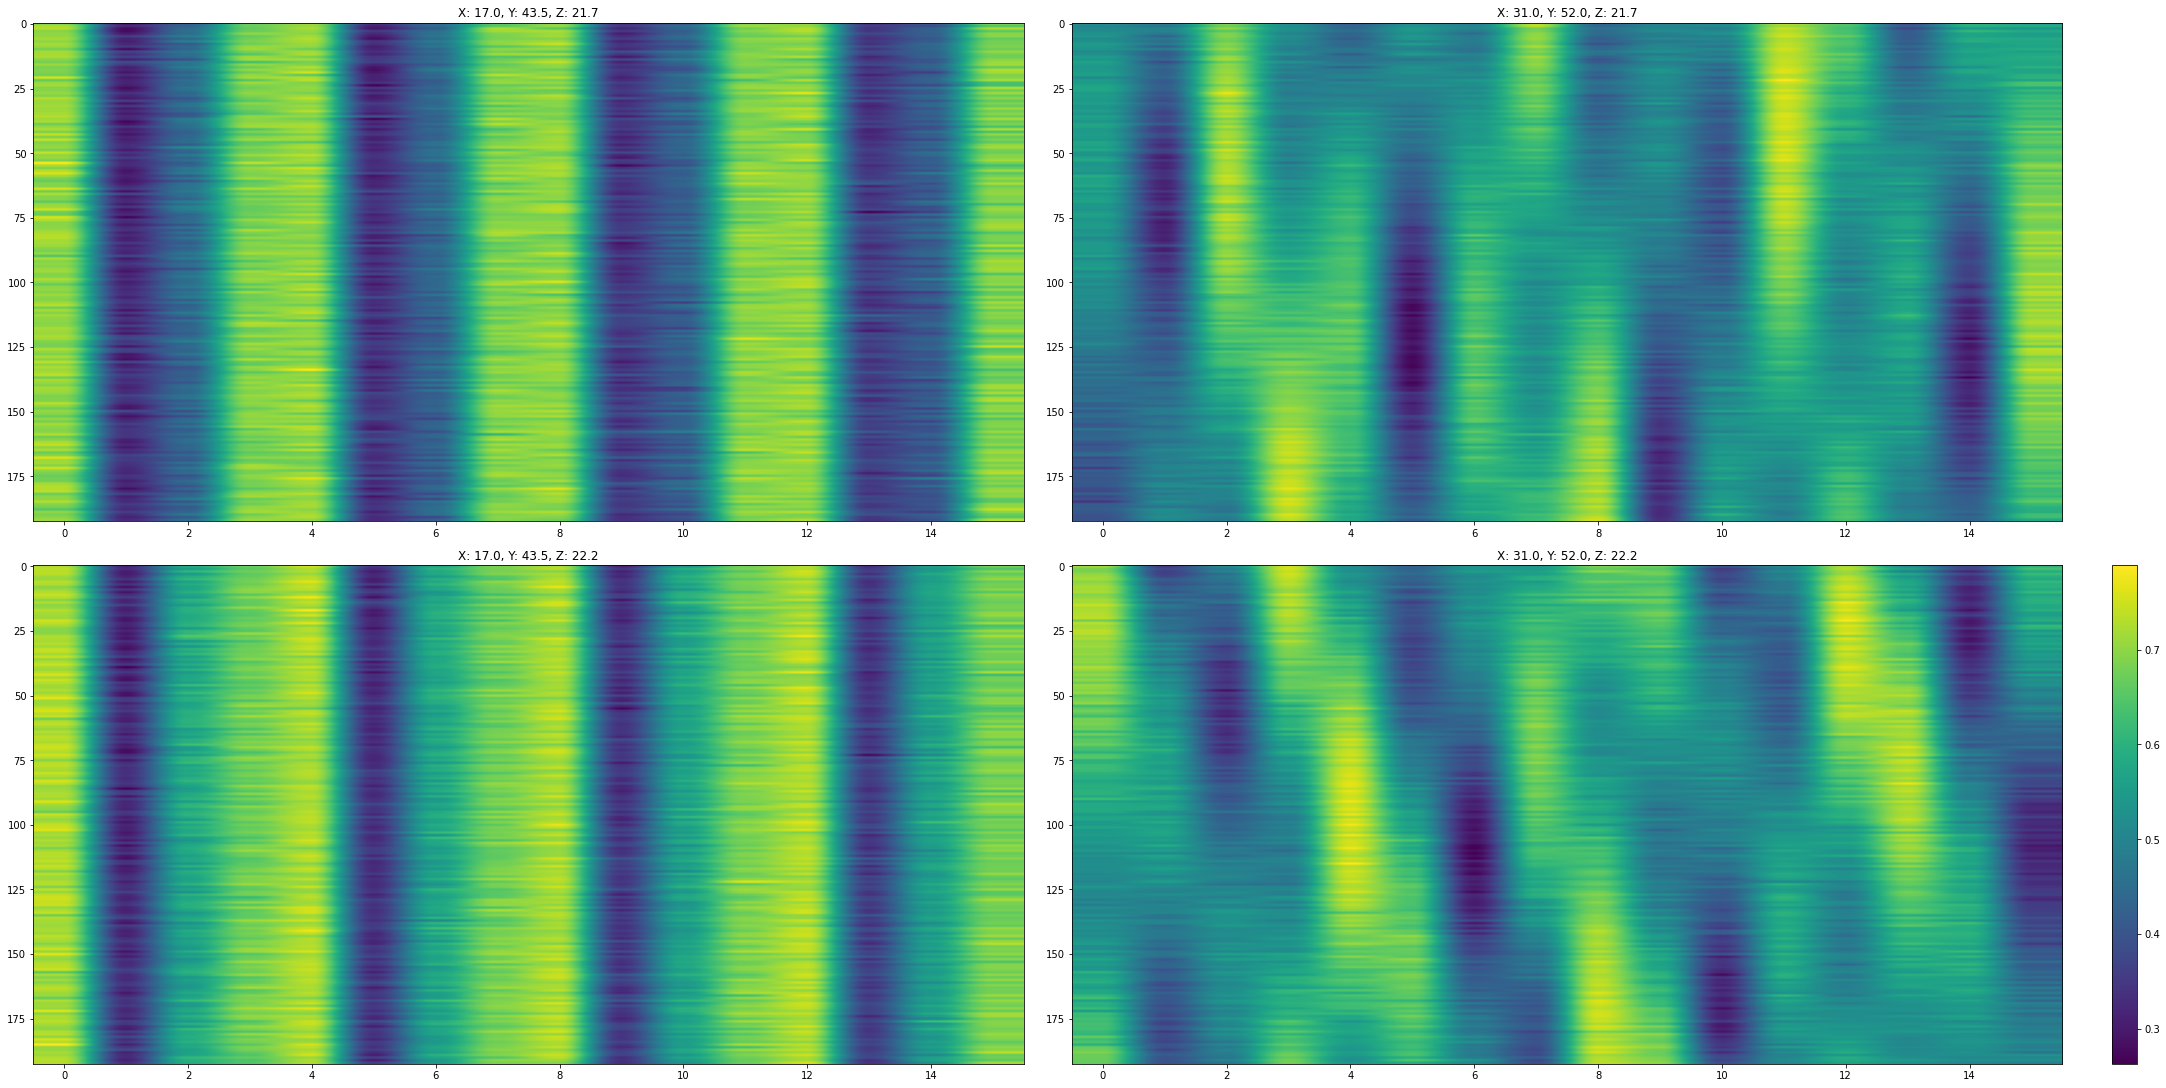

In [238]:
# Let's take the heatmap images from four different RP, each from the same UE.

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Obtain only measurements taken from the first UE
# print(features.shape)

first_ue_features = []

for i in range(len(features)):
    first_ue_features.append(features[i][0])
    
first_ue_features = np.array(first_ue_features)
# print(first_ue_features.shape)

fig, axs = plt.subplots(2,2, constrained_layout = True)

# Take reference points with index 0, 969, 1,938, 2,907

plt.colorbar(plt.imshow(first_ue_features[0].T))

axs[0,0].imshow(first_ue_features[0].T, aspect = 'auto') 
axs[0,0].title.set_text(f'X: {rp_dict[0][0]}, Y: {rp_dict[0][1]}, Z: {rp_dict[0][2]}')

axs[0,1].imshow(first_ue_features[969].T, aspect = 'auto')
axs[0,1].title.set_text(f'X: {rp_dict[969][0]}, Y: {rp_dict[969][1]}, Z: {rp_dict[969][2]}')

axs[1,0].imshow(first_ue_features[1938].T, aspect = 'auto')
axs[1,0].title.set_text(f'X: {rp_dict[1938][0]}, Y: {rp_dict[1938][1]}, Z: {rp_dict[1938][2]}')

axs[1,1].imshow(first_ue_features[2907].T, aspect = 'auto')
axs[1,1].title.set_text(f'X: {rp_dict[2907][0]}, Y: {rp_dict[2907][1]}, Z: {rp_dict[2907][2]}')

- Observation: For the same UE, heatmaps at different coordinates are distinctively different. For nearby coordinates which only differ by z-coordinate, difference is discernable enough.
- Conclusion: Fingerprints obtained at different coordinates can be used to identify coordinates.

In [239]:
# Lets compare heatmap from first UE to the other UE's heatmap images
def ssim_generate_heatmap(feature):

    im = plt.imshow(feature)
    plt.close() # for preventing heatmap from showing
    plt.clf() # clear current figure when done

    colour_vals_rgba = im.cmap(im.norm(im.get_array()))
    return tf.convert_to_tensor(colour_vals_rgba)

img1 = ssim_generate_heatmap(first_ue_features[0].T)
img2 = ssim_generate_heatmap(first_ue_features[969].T)
img3 = ssim_generate_heatmap(first_ue_features[1938].T)
img4 = ssim_generate_heatmap(first_ue_features[2907].T)

imgs = [img1, img2, img3, img4]
res = [[0]*4 for i in range(4)]

for i in range(4):
    for j in range(4-i):
        res[i][j] = tf.image.ssim(imgs[i], imgs[j], max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

print(res)

[[1.0, 0.46209517, 0.92599344, 0.46850348], [0.46209517, 1.0, 0.476507, 0], [0.92599344, 0.476507, 0, 0], [0.46850348, 0, 0, 0]]


<Figure size 2160x1080 with 0 Axes>

## 3. Prepare dataset using data from the first UE

In [240]:
# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

first_ue_features = []

for i in range(len(features)):
    first_ue_features.append(features[i][0])
    
first_ue_features = np.array(first_ue_features)

count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
# Would want to flatten the 4D np features array to a 3D np features array where (3876,4,16,193) --> (3876*4,16,193)
print(first_ue_features.shape)
print(labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((first_ue_features, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

print(dataset)

(3876, 16, 193)
(3876,)
<MapDataset element_spec=(TensorSpec(shape=(16, 193), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


## 4. Shuffle the dataset

In [241]:
# Numeric argument refers to size of buffer used in shuffling. Larger buffer size results in more thorough shuffling but requires more memory
dataset = dataset.shuffle(1000)
# reshuffle_each_iteration = False

## 5. Split dataset into train, test and validation sets

In [242]:
# 3. Split the dataset into train, test and validaiton set
def split_dataset(ds):
    size = len(ds)
    train_size = int(round(size*0.7))
    val_size = int(round(size*0.2))
    test_size = int(round(size*0.1))
          
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [243]:
print("Dataset description: ", dataset)
print("Dataset length: ", len(dataset))

Dataset description:  <ShuffleDataset element_spec=(TensorSpec(shape=(16, 193), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>
Dataset length:  3876


## 6. Batch the training and validation dataset

In [244]:
# 4. Batch the dataset
# Have 3,876*0.7 = 2,713 training data points, batch into 10 batches => 2,713/10 ~ 271
# Have 3,876*0.2 = 775 validation data points, batch into 10 batches => 775/10 ~ 77
train_batch_size = 271
batched_train_dataset = train_dataset.batch(train_batch_size).cache().prefetch(tf.data.AUTOTUNE)
val_batch_size = 77
batched_val_dataset = val_dataset.batch(val_batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [245]:
print(batched_train_dataset)
print(batched_val_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 16, 193), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 16, 193), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>


In [246]:
'''
# print(len(val_dataset))
# print(len(batched_val_dataset))

i = 0
for elm in batched_val_dataset:
    if i == 2:
        print(elm[0], elm[1])
        X_array = elm[0]
        Y_array = elm[1]
        X_val = X_array.numpy()
        # X_val = [np.array(x) for x in X_array]
        print(X_val)
        break
    i += 1
    
print(X_val.shape)

i = 0
for elm in batched_val_dataset:
    if i == 0:
        X_array = elm[0]
        Y_array = elm[1]
        print(type(X_array), X_array.shape)
        X_val = X_array.numpy()
        print(type(X_val), X_val.shape, X_val.dtype)
        break
    i += 1
    
'''

'\n# print(len(val_dataset))\n# print(len(batched_val_dataset))\n\ni = 0\nfor elm in batched_val_dataset:\n    if i == 2:\n        print(elm[0], elm[1])\n        X_array = elm[0]\n        Y_array = elm[1]\n        X_val = X_array.numpy()\n        # X_val = [np.array(x) for x in X_array]\n        print(X_val)\n        break\n    i += 1\n    \nprint(X_val.shape)\n\ni = 0\nfor elm in batched_val_dataset:\n    if i == 0:\n        X_array = elm[0]\n        Y_array = elm[1]\n        print(type(X_array), X_array.shape)\n        X_val = X_array.numpy()\n        print(type(X_val), X_val.shape, X_val.dtype)\n        break\n    i += 1\n    \n'

## 7. Create custom callbacks for validation and evaluation

In [254]:
# 5. Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val, batch_no):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.batch_no = batch_no
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print("\n")
        print("On epoch end, evaluating model")
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 1)
        print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i].numpy()[0]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]
            
            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        print(f'RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

## 8. For each batched training dataset,
- Preprocess data by converting to heatmaps
- Train the model with the batched dataset

In [255]:
# 6. For each batched trained dataset, train the model with the batched dataset
# Import model and prepare model for training
# Import model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For simplicity sake, put model in the same directory as this notebook
from resnet import resnet18

# 7. Only handle generation of heatmap after dataset is batched to prevent error from 
# tf.data.Dataset.map() function
def generate_heatmap(features):
    
    np_res = np.zeros((len(features),193,16,4), dtype = np.float64)
    i = 0
    
    for feature in features:
        # input features is tf.tensor
        feature = feature.numpy()
        # Convert to heatmap
        feature = feature.T
        im = plt.imshow(feature)

        # plt.figure(figsize=(1e4, 1e4)) # for visualising heatmap
        # plt.show() # for visualising heatmap

        plt.close() # for preventing heatmap from showing
        plt.clf() # clear current figure when done

        colour_vals_rgba = im.cmap(im.norm(im.get_array()))
        # colour_vals_rgb = colour_vals_rgba[:, :, :3]
        # np_res[i] = colour_vals_rgb
        np_res[i] = colour_vals_rgba
        
    # Convert back to tf
    tf_res = tf.convert_to_tensor(np_res)
    return tf_res
    
class Model:
    
    def __init__(self):
            
        # Create model
        inputs = keras.Input(shape = (193, 16, 4))
        outputs = resnet18(inputs, num_classes = 3876)
        self.model = keras.Model(inputs, outputs)
        
        # Compile model - Classification
        self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
      
        # Print out a model summary
        self.model.summary()
     
    def run(self, train_ds, val_ds):
        
        # Create a dictionary to store results
        self.results = {}
        batch_no = 1
        
        # Create callback to produce logs at the end of each epoch
        # logdir = 'logs'
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
            
        # Iterate through all batches
        for cur_batch in train_ds:
            
            print(f'Processing batch {batch_no}')
            
            X_train = cur_batch[0]
            X_train = generate_heatmap(X_train)
            Y_train = cur_batch[1]
            
            
            # Initialise custom callback at end of each epoch - To perform validation
            i = 0
            for val_batch in batched_val_dataset:
                
                if i == batch_no - 1:
                    X_val = val_batch[0]
                    X_val = generate_heatmap(X_val)
                    Y_val = val_batch[1]
                    break
                i += 1
            
            # Delete later, to see if model is even learning by validating against data it has seen before (training data)
            # val_callback = ValidationCallback(X_train, Y_train, batch_no)   
            val_callback = ValidationCallback(X_val, Y_val, batch_no)
            
            hist = self.model.fit(
                X_train, Y_train,
                epochs=20, batch_size=16,
                callbacks = [val_callback],
                verbose=1)
            
            key = 'batch_' + str(batch_no)
            batch_no += 1
            self.results[key] = hist

        print("All batches have been processed.")
                
    def test():
        pass
    
    def save():
        pass

#### Trial 1:

- Training batch size: 271 per batch for a total of 2713 data points
- Validation batch size: 77 per batch for a total of 775 data points
- Mini-batch size: 32
- Epochs: 20

In [256]:
# with validation
resnet18_model = Model()
resnet18_model.run(batched_train_dataset, batched_val_dataset)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 193, 16, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 199, 22, 4)   0           ['input_22[0][0]']               
                                                                                                  
 conv1 (Conv2D)                 (None, 97, 8, 64)    12544       ['conv1_pad[0][0]']              
                                                                                                  
 bn1 (BatchNormalization)       (None, 97, 8, 64)    256         ['conv1[0][0]']           

<Figure size 2160x1080 with 0 Axes>

In [257]:
print(resnet18_model.results)

{'batch_1': <keras.callbacks.History object at 0x7f89eae25040>, 'batch_2': <keras.callbacks.History object at 0x7f89ea854fa0>, 'batch_3': <keras.callbacks.History object at 0x7f8cf45db550>, 'batch_4': <keras.callbacks.History object at 0x7f8b99ed2d60>, 'batch_5': <keras.callbacks.History object at 0x7f885030a1f0>, 'batch_6': <keras.callbacks.History object at 0x7f8e0845be80>, 'batch_7': <keras.callbacks.History object at 0x7f8c1c5757f0>, 'batch_8': <keras.callbacks.History object at 0x7f8bba373940>, 'batch_9': <keras.callbacks.History object at 0x7f8ab2384fa0>, 'batch_10': <keras.callbacks.History object at 0x7f8a52f5e130>, 'batch_11': <keras.callbacks.History object at 0x7f8a520b2df0>}


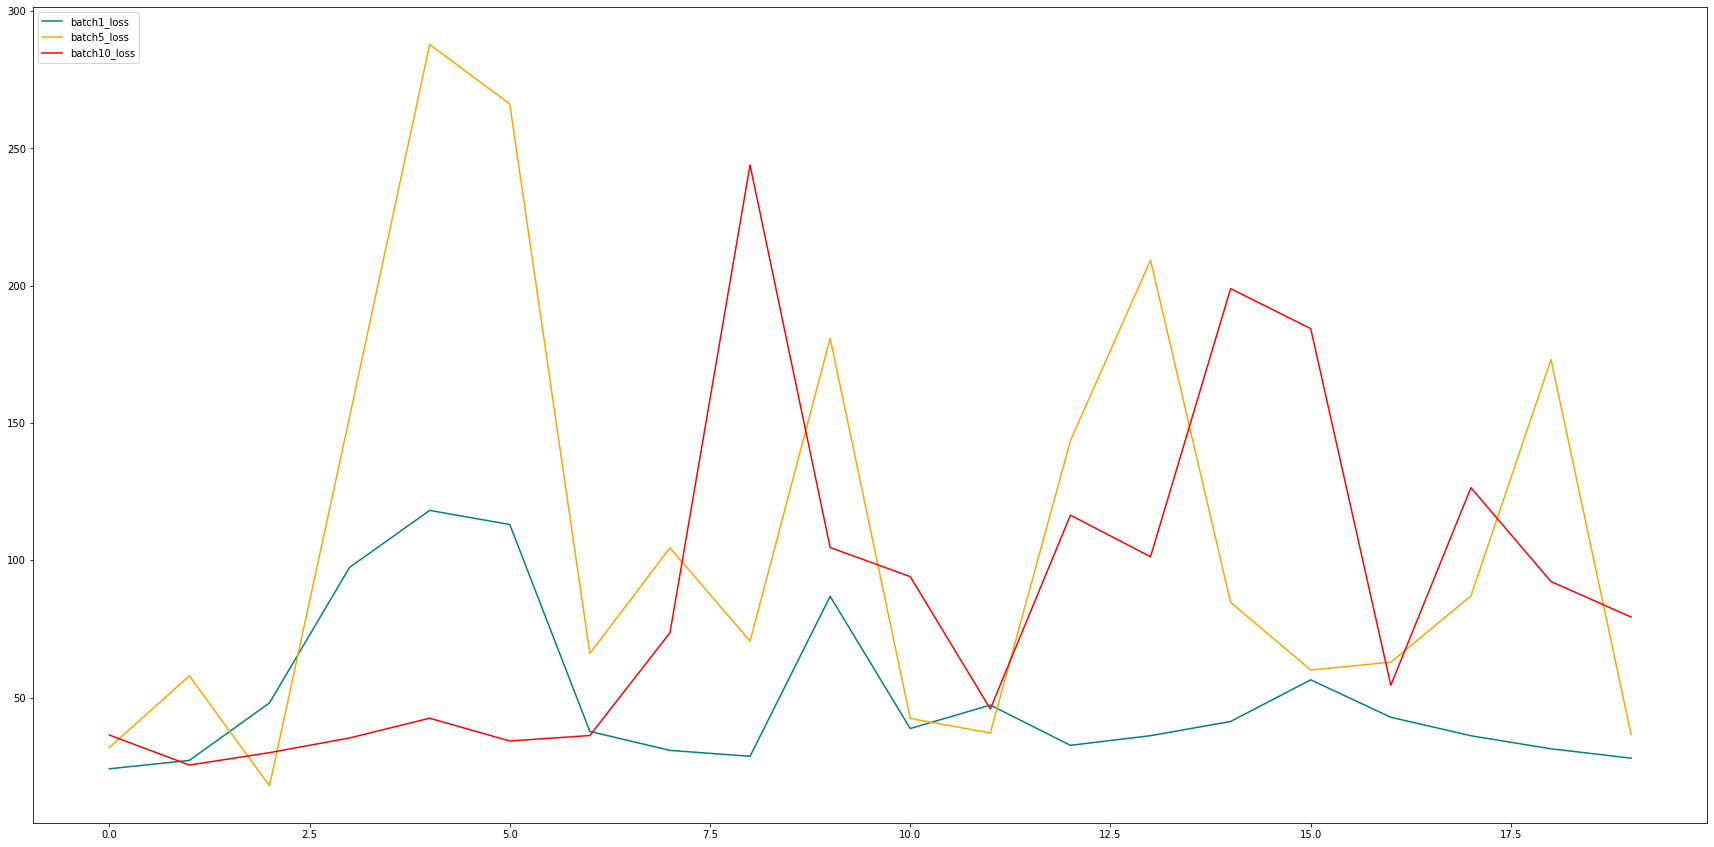

In [258]:
fig = plt.figure()

plt.plot(resnet18_model.results['batch_1'].history['val_loss'], color='teal', label='batch1_loss')
plt.plot(resnet18_model.results['batch_5'].history['val_loss'], color='orange', label='batch5_loss')
plt.plot(resnet18_model.results['batch_10'].history['val_loss'], color='red', label='batch10_loss')
# fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

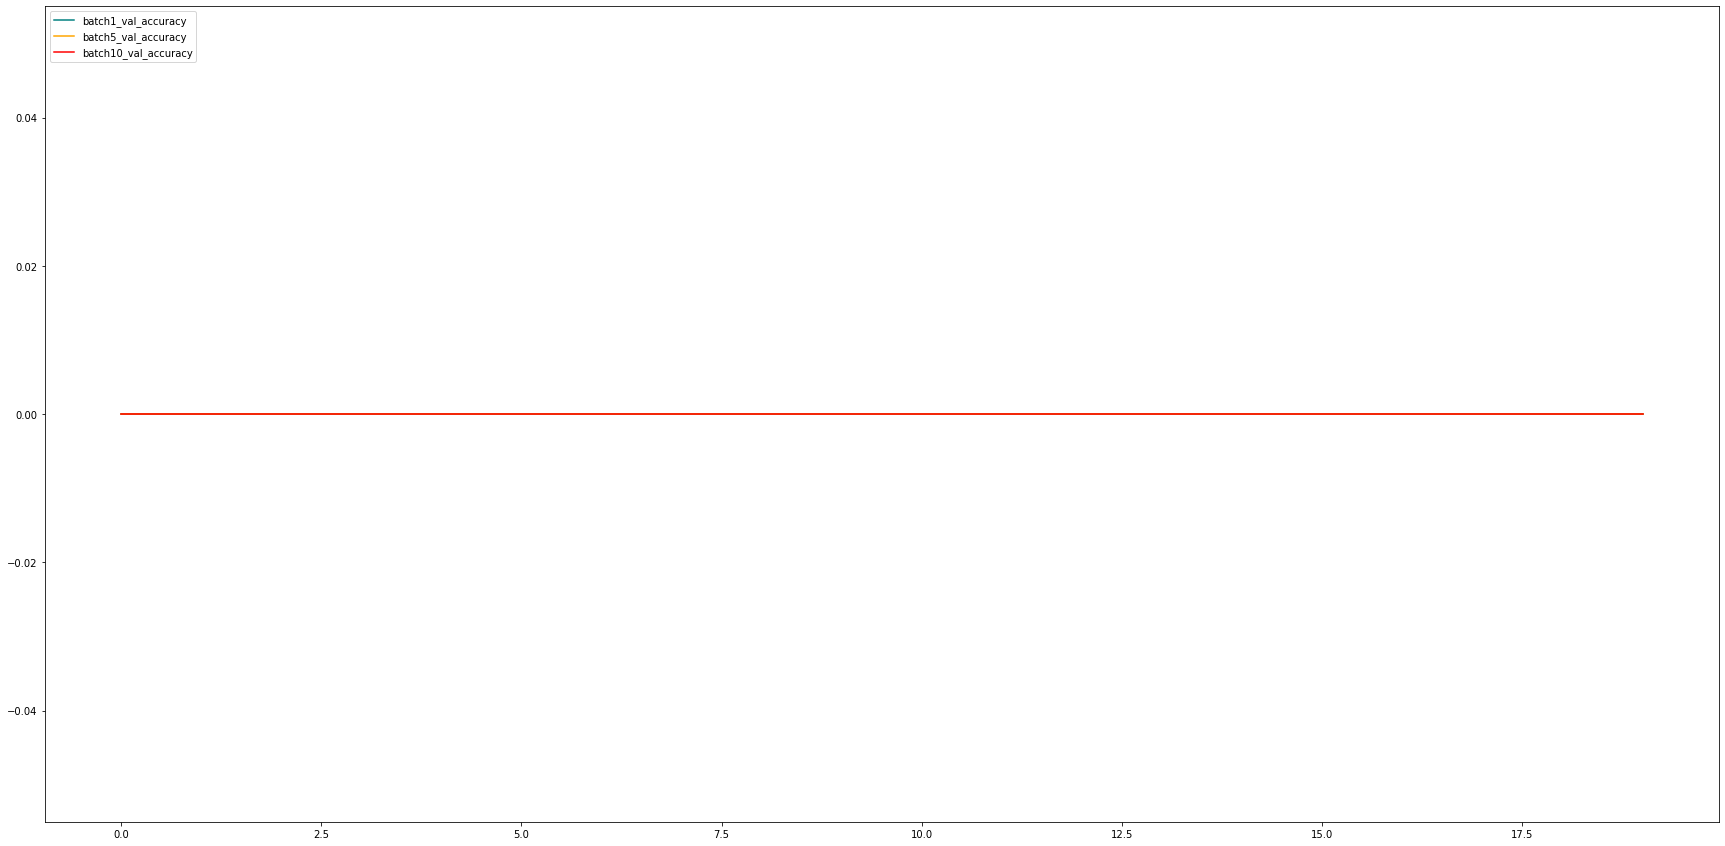

In [259]:
plt.plot(resnet18_model.results['batch_1'].history['val_accuracy'], color='teal', label='batch1_val_accuracy')
plt.plot(resnet18_model.results['batch_5'].history['val_accuracy'], color='orange', label='batch5_val_accuracy')
plt.plot(resnet18_model.results['batch_10'].history['val_accuracy'], color='red', label='batch10_val_accuracy')
plt.legend(loc='upper left')
plt.show()

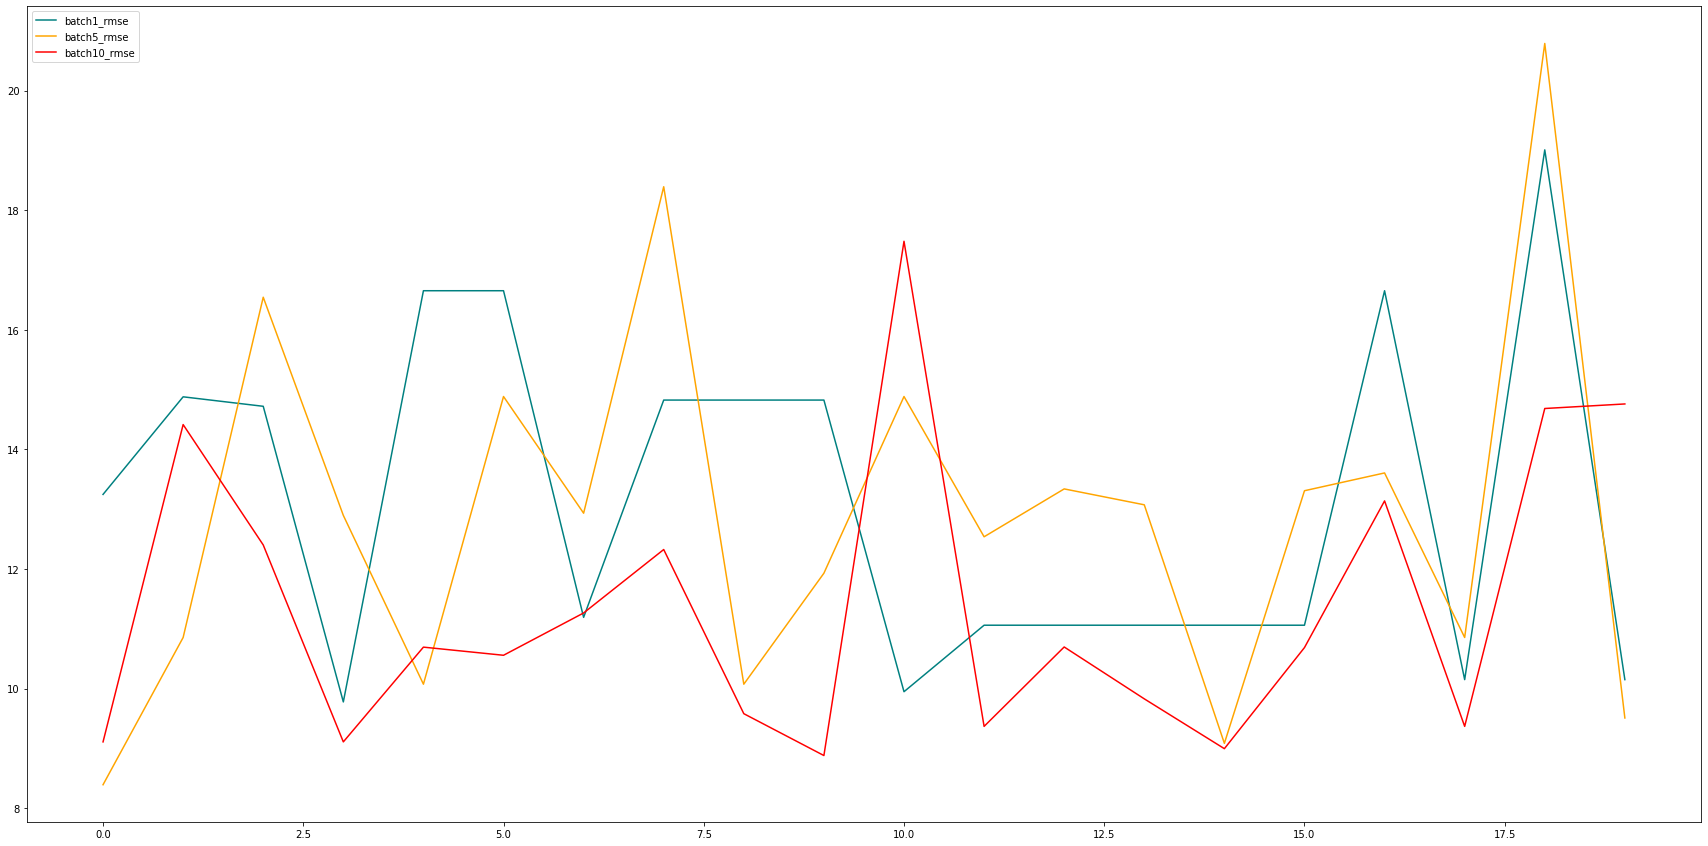

In [260]:
plt.plot(resnet18_model.results['batch_1'].history['rmse'], color='teal', label='batch1_rmse')
plt.plot(resnet18_model.results['batch_5'].history['rmse'], color='orange', label='batch5_rmse')
plt.plot(resnet18_model.results['batch_10'].history['rmse'], color='red', label='batch10_rmse')
plt.legend(loc='upper left')
plt.show()

## 9. Diagnosis

### Main Problem: Only have 1 fingerprint per class (coordinate labels) and this causes poor performance of CNN. Have to try to have more training images per class

### Solutions

1. Group points nearby to each other, based on a distance threshold, so that each class can have more training images.
    - Try to have 5 training image samples per class (set of coordinates)
    - Criteria needed:
        - Are the fingerprints between adjacent point similar? (From label dataset, take one point and set a distance threshold. Get all points within that distance threshold and assign them to that set of coordinates (class))
        - Clustered class (set of coordinates) should be the centroid of all coordinates in that cluster)

<br />

2. May be using the data wrongly
    - Since each matrix already has values between 0 and 1, do not need to convert matrix values to heatmap
    - Each UE is one image channel

<br/>

3. Could have compared training and validation loss against epoch to see if it is a case of high bias or variance. But, given that batch normalisation layers tend to cause validation loss to be much higher than training loss, it may not be useful to perform this diagnosis.

<br />

4. Augment the data
    - Adding noise
    - Dropout layers
    - Scaling
    - Cropping/Flipping/Padding/Rotation/Colour related augmentation
    - Regularisation

## 9.1 Diagnosis Method 2
### Data Handling Method 1

- Since each matrix already has values between 0 and 1, do not need to convert matrix values to heatmap
- Data in this dataset only has one channel corresponding to measurements from one base station
- In this case, we can construct the heatmap images using measurements from that one base station, with each heatmap image channel being measurements from each of the 4 UEs. 4 UEs -> 4 channels.

In [108]:
# may delete later
# New way to import the data
import h5py
import numpy as np
import tensorflow as tf

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16,4), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
print(features_transposed.shape)
print(labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_transposed, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

print(dataset)

(3876, 193, 16, 4)
(3876,)
<MapDataset element_spec=(TensorSpec(shape=(193, 16, 4), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [109]:
# Numeric argument refers to size of buffer used in shuffling. Larger buffer size results in more thorough shuffling but requires more memory
dataset = dataset.shuffle(1000)
# reshuffle_each_iteration = False

In [110]:
# 3. Split the dataset into train, test and validaiton set
def split_dataset(ds):
    size = len(ds)
    train_size = int(round(size*0.7))
    val_size = int(round(size*0.2))
    test_size = int(round(size*0.1))
          
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [111]:
print("Dataset description: ", dataset)
print("Dataset length: ", len(dataset))

Dataset description:  <ShuffleDataset element_spec=(TensorSpec(shape=(193, 16, 4), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>
Dataset length:  3876


In [46]:
# 4. Batch the dataset
# Have 3,876*0.7 = 2,713 training data points, batch into 10 batches => 2,713/10 ~ 271
# Have 3,876*0.2 = 775 validation data points, batch into 10 batches => 775/10 ~ 77
train_batch_size = 271
batched_train_dataset = train_dataset.batch(train_batch_size).cache().prefetch(tf.data.AUTOTUNE)
val_batch_size = 77
batched_val_dataset = val_dataset.batch(val_batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [47]:
print(batched_train_dataset)
print(batched_val_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 193, 16, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 193, 16, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>


In [114]:
# 5. Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val, batch_no):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.batch_no = batch_no
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print("\n")
        print("On epoch end, evaluating model")
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 1)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i].numpy()[0]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]
            
            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        print(f'RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [115]:
# 6. For each batched trained dataset, train the model with the batched dataset
# Import model and prepare model for training
# Import model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For simplicity sake, put model in the same directory as this notebook
from resnet import resnet18

# 7. Only handle generation of heatmap after dataset is batched to prevent error from 
# tf.data.Dataset.map() function
def generate_heatmap(features):
    
    np_res = np.zeros((len(features),193,16,4), dtype = np.float64)
    i = 0
    
    for feature in features:
        # input features is tf.tensor
        feature = feature.numpy()
        # Convert to heatmap
        feature = feature.T
        im = plt.imshow(feature)

        # plt.figure(figsize=(1e4, 1e4)) # for visualising heatmap
        # plt.show() # for visualising heatmap

        plt.close() # for preventing heatmap from showing
        plt.clf() # clear current figure when done

        colour_vals_rgba = im.cmap(im.norm(im.get_array()))
        # colour_vals_rgb = colour_vals_rgba[:, :, :3]
        # np_res[i] = colour_vals_rgb
        np_res[i] = colour_vals_rgba
        
    # Convert back to tf
    tf_res = tf.convert_to_tensor(np_res)
    return tf_res
    
class Model:
    
    def __init__(self):
            
        # Create model
        inputs = keras.Input(shape = (193, 16,4))
        outputs = resnet18(inputs, num_classes = 3876)
        self.model = keras.Model(inputs, outputs)
        
        # Compile model - Classification
        self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
      
        # Print out a model summary
        self.model.summary()
        
        # Print out model metrics
        print(self.model.metrics_names)
     
    def run(self, train_ds, val_ds):
        
        # Create a dictionary to store results
        self.results = {}
        batch_no = 1
        
        # Create callback to produce logs at the end of each epoch
        # logdir = 'logs'
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
            
        # Iterate through all batches
        for cur_batch in train_ds:
            
            print(f'Processing batch {batch_no}')
            
            X_train = cur_batch[0]
            Y_train = cur_batch[1]
            
            
            # Initialise custom callback at end of each epoch - To perform validation
            i = 0
            for val_batch in batched_val_dataset:
                
                if i == batch_no - 1:
                    X_val = val_batch[0]
                    Y_val = val_batch[1]
                    break
                i += 1
            
            # Delete later, to see if model is even learning by validating against data it has seen before (training data)
            # val_callback = ValidationCallback(X_train, Y_train, batch_no)   
            val_callback = ValidationCallback(X_val, Y_val, batch_no)
            
            hist = self.model.fit(
                X_train, Y_train,
                epochs=20, batch_size=16,
                callbacks = [val_callback],
                verbose=1)
            
            key = 'batch_' + str(batch_no)
            batch_no += 1
            self.results[key] = hist

        print("All batches have been processed.")
                
    def test():
        pass
    
    def save():
        pass

In [116]:
# with validation
resnet18_model = Model()
resnet18_model.run(batched_train_dataset, batched_val_dataset)

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 193, 16, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 199, 22, 4)   0           ['input_27[0][0]']               
                                                                                                  
 conv1 (Conv2D)                 (None, 97, 8, 64)    12544       ['conv1_pad[0][0]']              
                                                                                                  
 bn1 (BatchNormalization)       (None, 97, 8, 64)    256         ['conv1[0][0]']           

2023-06-07 05:29:51.850378: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


16/17 [===========================>..] - ETA: 0s - loss: 9.9818 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 6ms/step - loss: 9.4718 - accuracy: 0.0000e+00
RMSE: 11.117874925413707
17/17 [==============================] - 2s 51ms/step - loss: 9.9660 - accuracy: 0.0000e+00 - val_loss: 9.4718 - val_accuracy: 0.0000e+00 - rmse: 11.1179
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 8.9499 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.6937 - accuracy: 0.0000e+00
RMSE: 16.071269840485982
17/17 [==============================] - 0s 19ms/step - loss: 8.9499 - accuracy: 0.0000e+00 - val_loss: 11.6937 - val_accuracy: 0.0000e+00 - rmse: 16.0713
Epoch 3/20
16/17 [===========================>..] - ETA: 0s - loss: 6.0070 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 14.1035 - accuracy: 0.00

2023-06-07 05:30:02.735112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


16/17 [===========================>..] - ETA: 0s - loss: 10.7836 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.4403 - accuracy: 0.0000e+00
RMSE: 15.372960745345123
17/17 [==============================] - 1s 75ms/step - loss: 10.6720 - accuracy: 0.0000e+00 - val_loss: 10.4403 - val_accuracy: 0.0000e+00 - rmse: 15.3730
Epoch 2/20
16/17 [===========================>..] - ETA: 0s - loss: 6.8723 - accuracy: 0.0117  

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.8243 - accuracy: 0.0000e+00
RMSE: 15.888205214405588
17/17 [==============================] - 0s 19ms/step - loss: 6.7512 - accuracy: 0.0148 - val_loss: 10.8243 - val_accuracy: 0.0000e+00 - rmse: 15.8882
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 4.7036 - accuracy: 0.0590

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 12.7293 - accuracy: 0.0130
RMS

2023-06-07 05:30:13.633944: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


16/17 [===========================>..] - ETA: 0s - loss: 11.0931 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.1576 - accuracy: 0.0130
RMSE: 12.828413067023599
17/17 [==============================] - 0s 24ms/step - loss: 11.1110 - accuracy: 0.0000e+00 - val_loss: 11.1576 - val_accuracy: 0.0130 - rmse: 12.8284
Epoch 2/20
16/17 [===========================>..] - ETA: 0s - loss: 6.5768 - accuracy: 0.0156

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.6908 - accuracy: 0.0000e+00
RMSE: 16.889153516192174
17/17 [==============================] - 0s 19ms/step - loss: 6.5412 - accuracy: 0.0148 - val_loss: 10.6908 - val_accuracy: 0.0000e+00 - rmse: 16.8892
Epoch 3/20
16/17 [===========================>..] - ETA: 0s - loss: 5.1805 - accuracy: 0.0430

On epoch end, evaluating model
3/3 [==============================] - 0s 6ms/step - loss: 12.3626 - accuracy: 0.0130
RMSE: 12.8243

2023-06-07 05:30:22.455801: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


16/17 [===========================>..] - ETA: 0s - loss: 11.6746 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 6ms/step - loss: 16.0754 - accuracy: 0.0000e+00
RMSE: 11.289001658320299
17/17 [==============================] - 0s 20ms/step - loss: 11.6882 - accuracy: 0.0000e+00 - val_loss: 16.0754 - val_accuracy: 0.0000e+00 - rmse: 11.2890
Epoch 2/20
16/17 [===========================>..] - ETA: 0s - loss: 6.3598 - accuracy: 0.0273

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.3389 - accuracy: 0.0000e+00
RMSE: 11.418684847055006
17/17 [==============================] - 0s 20ms/step - loss: 6.3185 - accuracy: 0.0258 - val_loss: 10.3389 - val_accuracy: 0.0000e+00 - rmse: 11.4187
Epoch 3/20
16/17 [===========================>..] - ETA: 0s - loss: 4.7047 - accuracy: 0.0391

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.0875 - accuracy: 0.0000e+00
R

2023-06-07 05:30:32.329371: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


16/17 [===========================>..] - ETA: 0s - loss: 11.9349 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.5475 - accuracy: 0.0000e+00
RMSE: 15.138752200291085
17/17 [==============================] - 0s 20ms/step - loss: 11.8229 - accuracy: 0.0000e+00 - val_loss: 10.5475 - val_accuracy: 0.0000e+00 - rmse: 15.1388
Epoch 2/20
16/17 [===========================>..] - ETA: 0s - loss: 6.6750 - accuracy: 0.0039

On epoch end, evaluating model
3/3 [==============================] - 0s 6ms/step - loss: 10.7097 - accuracy: 0.0000e+00
RMSE: 13.802526589713214
17/17 [==============================] - 0s 19ms/step - loss: 6.6651 - accuracy: 0.0037 - val_loss: 10.7097 - val_accuracy: 0.0000e+00 - rmse: 13.8025
Epoch 3/20
16/17 [===========================>..] - ETA: 0s - loss: 5.2181 - accuracy: 0.0273

On epoch end, evaluating model
3/3 [==============================] - 0s 6ms/step - loss: 11.1179 - accuracy: 0.0000e+00
R

2023-06-07 05:30:42.193889: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/20
16/17 [===========================>..] - ETA: 0s - loss: 12.4913 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 12.3923 - accuracy: 0.0000e+00
RMSE: 15.21587090089579
17/17 [==============================] - 0s 19ms/step - loss: 12.3987 - accuracy: 0.0000e+00 - val_loss: 12.3923 - val_accuracy: 0.0000e+00 - rmse: 15.2159
Epoch 2/20
16/17 [===========================>..] - ETA: 0s - loss: 6.0631 - accuracy: 0.0039  

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.0308 - accuracy: 0.0000e+00
RMSE: 11.99769999603279
17/17 [==============================] - 0s 20ms/step - loss: 6.0467 - accuracy: 0.0037 - val_loss: 10.0308 - val_accuracy: 0.0000e+00 - rmse: 11.9977
Epoch 3/20
16/17 [===========================>..] - ETA: 0s - loss: 4.1672 - accuracy: 0.1133

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 13.4451 - accuracy: 0

2023-06-07 05:30:51.882872: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


17/17 [==============================] - ETA: 0s - loss: 12.1719 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.2140 - accuracy: 0.0130
RMSE: 13.628894058094122
17/17 [==============================] - 0s 20ms/step - loss: 12.1719 - accuracy: 0.0000e+00 - val_loss: 11.2140 - val_accuracy: 0.0130 - rmse: 13.6289
Epoch 2/20
16/17 [===========================>..] - ETA: 0s - loss: 6.2648 - accuracy: 0.0039

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.2504 - accuracy: 0.0000e+00
RMSE: 13.06564345759668
17/17 [==============================] - 0s 19ms/step - loss: 6.2904 - accuracy: 0.0037 - val_loss: 10.2504 - val_accuracy: 0.0000e+00 - rmse: 13.0656
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 4.5243 - accuracy: 0.0554

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 13.1702 - accuracy: 0.0000e+00
RMSE: 12.4

2023-06-07 05:31:02.125363: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


16/17 [===========================>..] - ETA: 0s - loss: 12.7971 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.2680 - accuracy: 0.0000e+00
RMSE: 14.76020448244659
17/17 [==============================] - 0s 19ms/step - loss: 12.6699 - accuracy: 0.0000e+00 - val_loss: 10.2680 - val_accuracy: 0.0000e+00 - rmse: 14.7602
Epoch 2/20
16/17 [===========================>..] - ETA: 0s - loss: 6.0708 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.1429 - accuracy: 0.0519
RMSE: 12.328037941234586
17/17 [==============================] - 1s 31ms/step - loss: 6.0348 - accuracy: 0.0000e+00 - val_loss: 10.1429 - val_accuracy: 0.0519 - rmse: 12.3280
Epoch 3/20
16/17 [===========================>..] - ETA: 0s - loss: 3.8435 - accuracy: 0.1680

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 12.3231 - accuracy: 0.0390
RMSE: 

2023-06-07 05:31:12.155237: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


16/17 [===========================>..] - ETA: 0s - loss: 12.9030 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.0797 - accuracy: 0.0000e+00
RMSE: 13.268946268070238
17/17 [==============================] - 0s 19ms/step - loss: 12.7455 - accuracy: 0.0000e+00 - val_loss: 11.0797 - val_accuracy: 0.0000e+00 - rmse: 13.2689
Epoch 2/20
16/17 [===========================>..] - ETA: 0s - loss: 6.0959 - accuracy: 0.0078

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.3142 - accuracy: 0.0130
RMSE: 11.476401535664053
17/17 [==============================] - 0s 24ms/step - loss: 6.0676 - accuracy: 0.0074 - val_loss: 11.3142 - val_accuracy: 0.0130 - rmse: 11.4764
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 3.9244 - accuracy: 0.1587

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 12.2733 - accuracy: 0.0260
RMSE: 11.1353

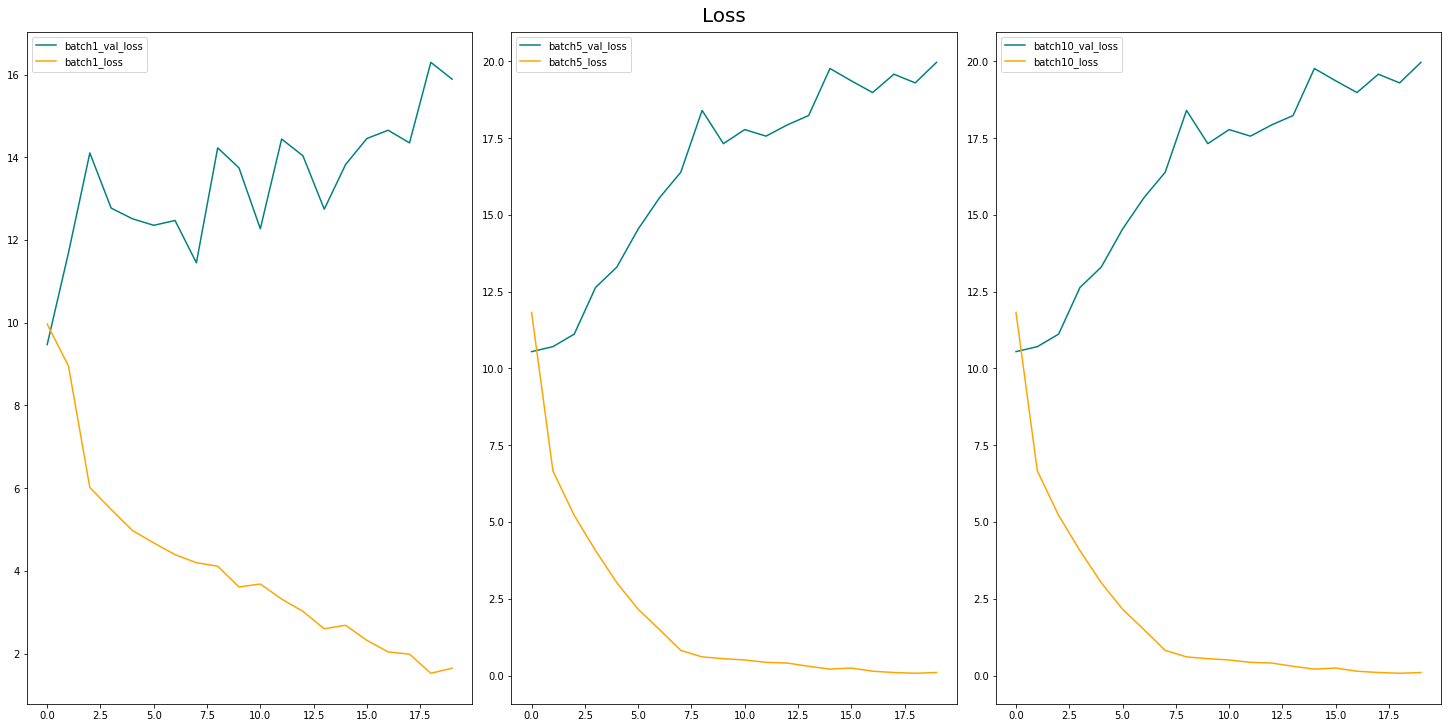

In [117]:
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(resnet18_model.results['batch_1'].history['val_loss'], color='teal', label='batch1_val_loss')
axs[0].plot(resnet18_model.results['batch_1'].history['loss'], color='orange', label='batch1_loss')
axs[0].legend(loc='upper left')

axs[1].plot(resnet18_model.results['batch_5'].history['val_loss'], color='teal', label='batch5_val_loss')
axs[1].plot(resnet18_model.results['batch_5'].history['loss'], color='orange', label='batch5_loss')
axs[1].legend(loc='upper left')

axs[2].plot(resnet18_model.results['batch_5'].history['val_loss'], color='teal', label='batch10_val_loss')
axs[2].plot(resnet18_model.results['batch_5'].history['loss'], color='orange', label='batch10_loss')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

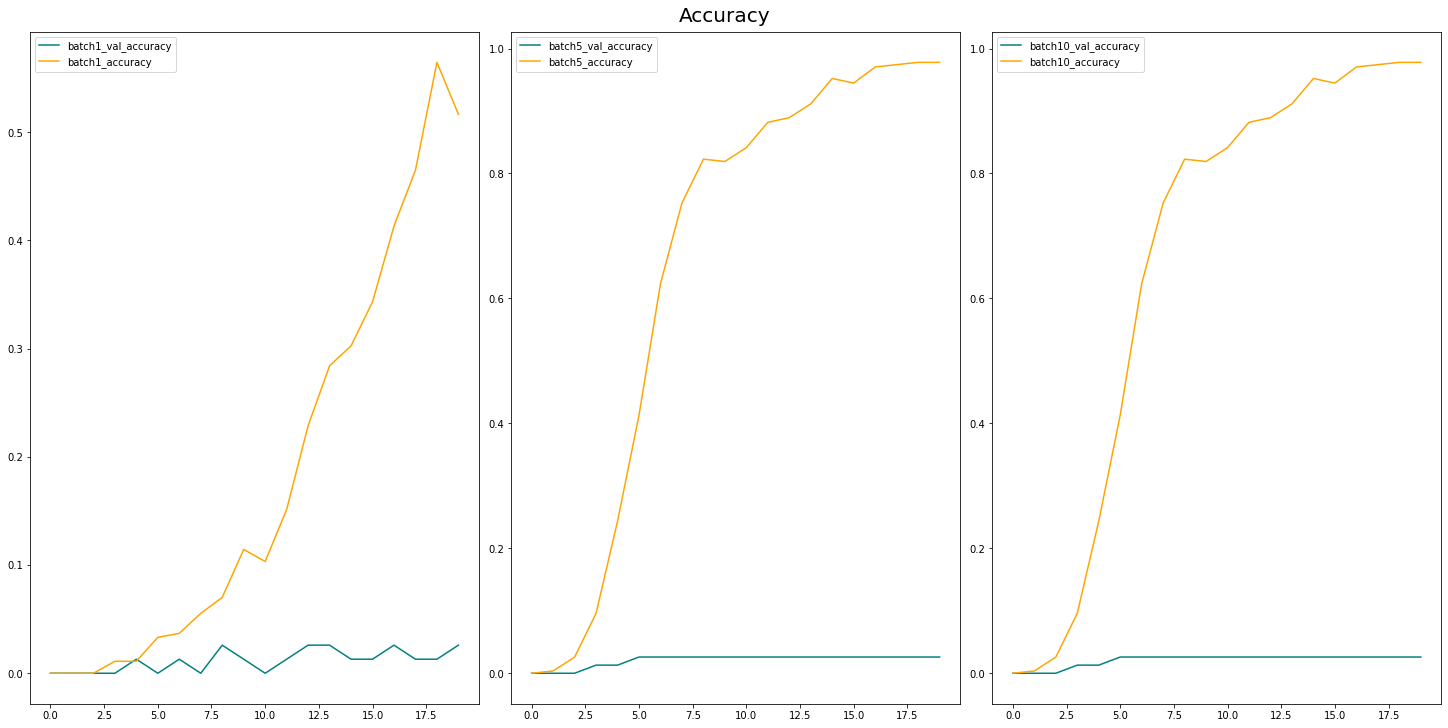

In [118]:
fig, axs = plt.subplots(1, 3, constrained_layout = True)

axs[0].plot(resnet18_model.results['batch_1'].history['val_accuracy'], color='teal', label='batch1_val_accuracy')
axs[0].plot(resnet18_model.results['batch_1'].history['accuracy'], color='orange', label='batch1_accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(resnet18_model.results['batch_5'].history['val_accuracy'], color='teal', label='batch5_val_accuracy')
axs[1].plot(resnet18_model.results['batch_5'].history['accuracy'], color='orange', label='batch5_accuracy')
axs[1].legend(loc='upper left')

axs[2].plot(resnet18_model.results['batch_5'].history['val_accuracy'], color='teal', label='batch10_val_accuracy')
axs[2].plot(resnet18_model.results['batch_5'].history['accuracy'], color='orange', label='batch10_accuracy')
axs[2].legend(loc='upper left')

fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

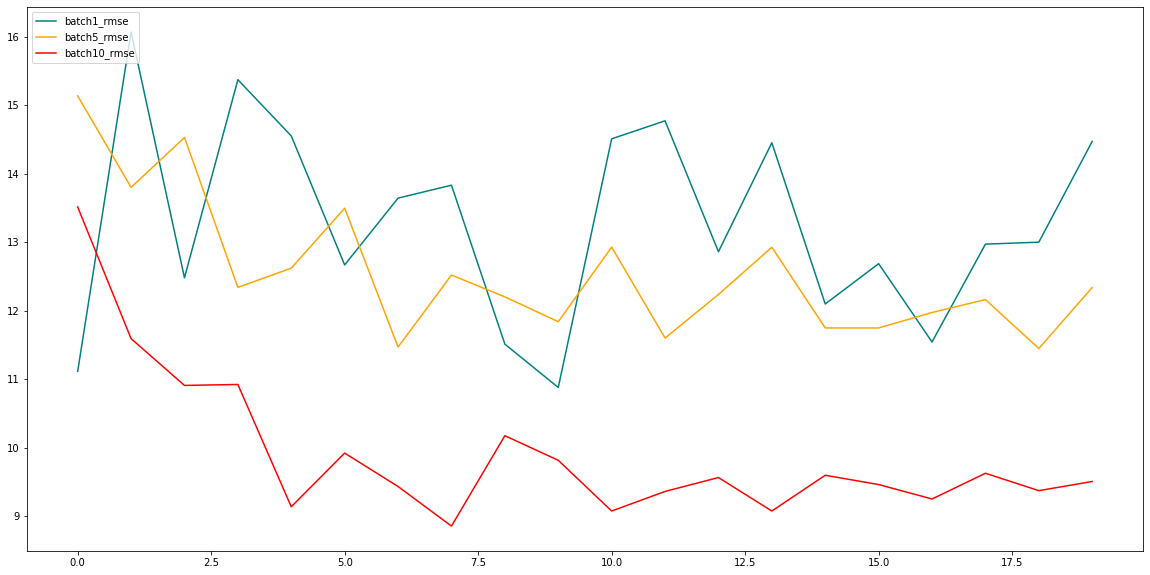

In [119]:
plt.plot(resnet18_model.results['batch_1'].history['rmse'], color='teal', label='batch1_rmse')
plt.plot(resnet18_model.results['batch_5'].history['rmse'], color='orange', label='batch5_rmse')
plt.plot(resnet18_model.results['batch_10'].history['rmse'], color='red', label='batch10_rmse')
plt.legend(loc='upper left')
plt.show()

### Observations:

- High validation loss and low training loss (Overfitting)
    - K-Fold Cross Validation (Determine optimal batch size and epochs)
    - Clustering of data points (Reduce no. of classes while increasing no. of samples per class)
    - Random Gaussian Noise at the inputs

### K-Fold Cross Validation

In [120]:
# 5. Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i][0]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        # print(f'RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [121]:
# What we have so far
from sklearn.model_selection import KFold

# print(features_transposed.shape)
# print(labels.shape)

# Get the images and labels for train and validation test set
train_features = np.array(list(train_dataset.map(lambda x,y : x)))
train_labels = np.array(list(train_dataset.map(lambda x,y : y)))

val_features = np.array(list(val_dataset.map(lambda x,y : x)))
val_labels = np.array(list(val_dataset.map(lambda x,y : y)))

# Split the data using K Fold algorithm
inputs = np.concatenate((train_features, val_features), axis = 0)
targets = np.concatenate((train_labels, val_labels), axis = 0)
kfold = KFold(n_splits = 10, shuffle = True)

# For each of the train, test
split_no = 1
results = {}

# Perform K Fold Validation
for train, val in kfold.split(inputs, targets):
    
    # Make model
    print(f'Processing split {split_no}')
    
    split_results = {}
    # Create model
    model_inputs = keras.Input(shape = (193, 16, 4))
    model_outputs = resnet18(model_inputs, num_classes = 3876)
    resnet18_model = keras.Model(model_inputs, model_outputs)

# Compile model - Classification
    resnet18_model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

    # Get the metrics
    val_callback = ValidationCallback(inputs[val], targets[val])
    hist = resnet18_model.fit(inputs[train], targets[train], batch_size = 32, callbacks = [val_callback], epochs = 20)
    split_results['loss'] = hist.history['loss']
    split_results['accuracy'] = hist.history['accuracy']
    split_results['val_loss'] = hist.history['val_loss']
    split_results['val_accuracy'] = hist.history['val_accuracy']
    split_results['rmse'] = hist.history['rmse']
    
    cur_split = 'split_' + str(split_no)
    results[cur_split] = split_results

    split_no += 1

print('All splits processed.')

Processing split 1
Epoch 1/20
95/99 [===========================>..] - ETA: 0s - loss: 9.3555 - accuracy: 0.0000e+00

Epoch End - Custom Validation Callback
99/99 [==============================] - 3s 18ms/step - loss: 9.3286 - accuracy: 0.0000e+00 - val_loss: 8.5633 - val_accuracy: 0.0000e+00 - rmse: 10.4951
Epoch 2/20
97/99 [============================>.] - ETA: 0s - loss: 8.1852 - accuracy: 0.0000e+00

Epoch End - Custom Validation Callback
99/99 [==============================] - 1s 14ms/step - loss: 8.1869 - accuracy: 0.0000e+00 - val_loss: 9.5697 - val_accuracy: 0.0000e+00 - rmse: 16.9203
Epoch 3/20
95/99 [===========================>..] - ETA: 0s - loss: 8.0724 - accuracy: 0.0000e+00

Epoch End - Custom Validation Callback
99/99 [==============================] - 1s 13ms/step - loss: 8.0733 - accuracy: 0.0000e+00 - val_loss: 9.3896 - val_accuracy: 0.0000e+00 - rmse: 14.0926
Epoch 4/20
98/99 [============================>.] - ETA: 0s - loss: 7.9753 - accuracy: 0.0000e+00

Epoch 

<Figure size 1440x720 with 0 Axes>

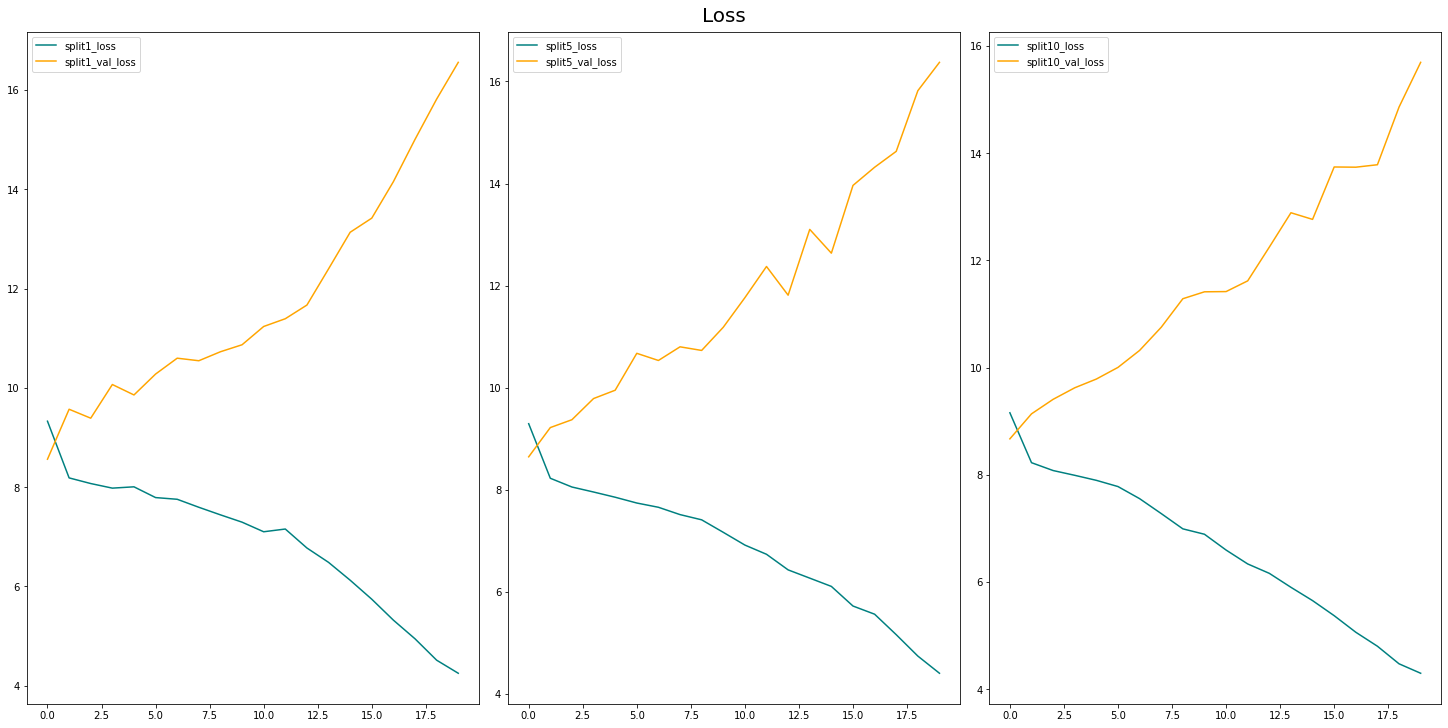

In [122]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['loss'], color='teal', label='split1_loss')
axs[0].plot(results['split_1']['val_loss'], color='orange', label='split1_val_loss')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_5']['loss'], color='teal', label='split5_loss')
axs[1].plot(results['split_5']['val_loss'], color='orange', label='split5_val_loss')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_10']['loss'], color='teal', label='split10_loss')
axs[2].plot(results['split_10']['val_loss'], color='orange', label='split10_val_loss')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

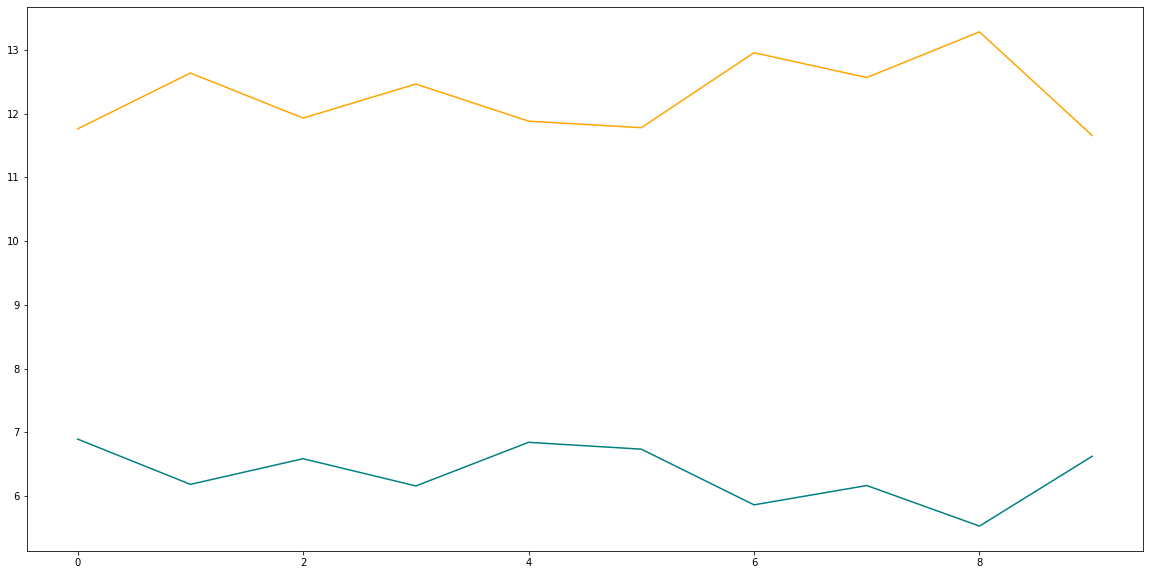

In [123]:
trg_loss = []
val_loss = []

for keys, values in results.items():

    trg_loss_avg = sum(results[keys]['loss'])/len(results[keys]['loss'])
    val_loss_avg = sum(results[keys]['val_loss'])/len(results[keys]['val_loss'])
    trg_loss.append(trg_loss_avg)
    val_loss.append(val_loss_avg)

plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))

plt.plot(trg_loss, color='teal', label='trg_loss')
plt.plot(val_loss, color='orange', label='val_loss')

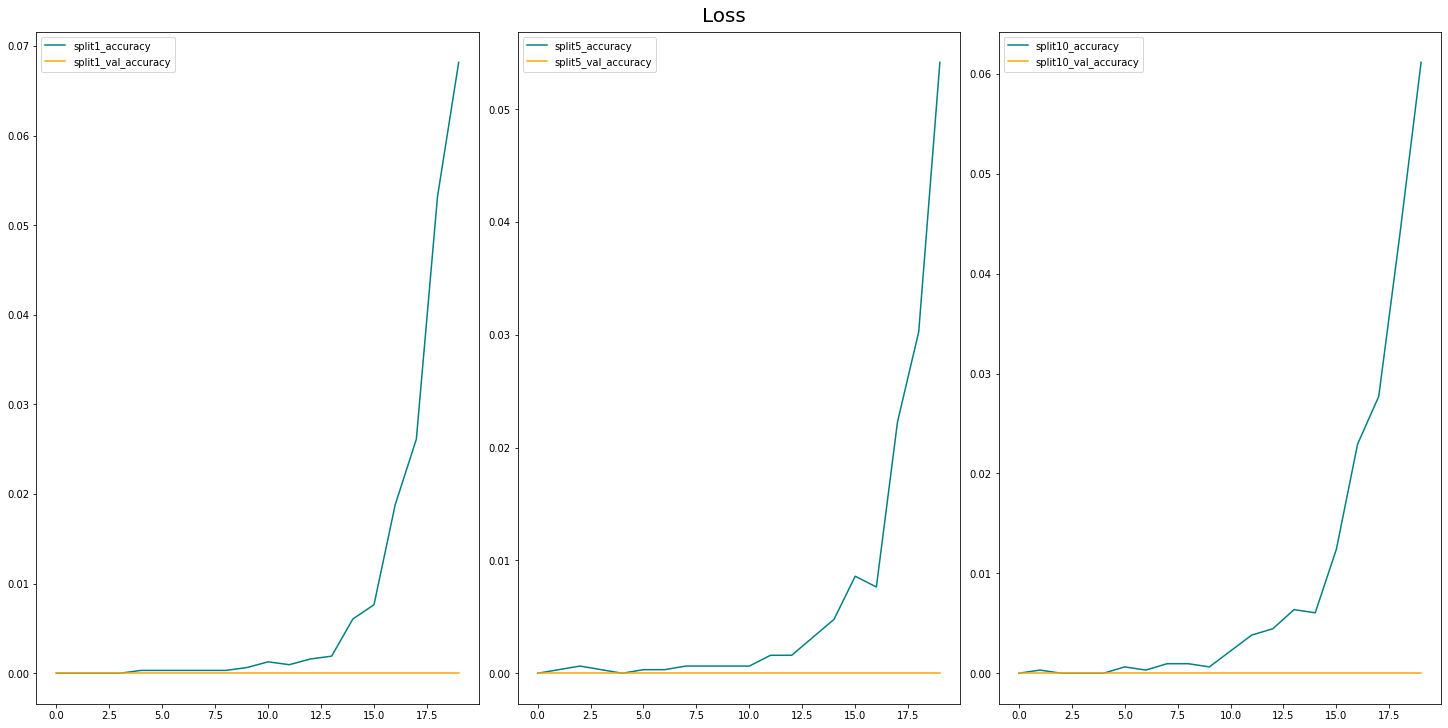

In [124]:
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['accuracy'], color='teal', label='split1_accuracy')
axs[0].plot(results['split_1']['val_accuracy'], color='orange', label='split1_val_accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_5']['accuracy'], color='teal', label='split5_accuracy')
axs[1].plot(results['split_5']['val_accuracy'], color='orange', label='split5_val_accuracy')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_10']['accuracy'], color='teal', label='split10_accuracy')
axs[2].plot(results['split_10']['val_accuracy'], color='orange', label='split10_val_accuracy')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

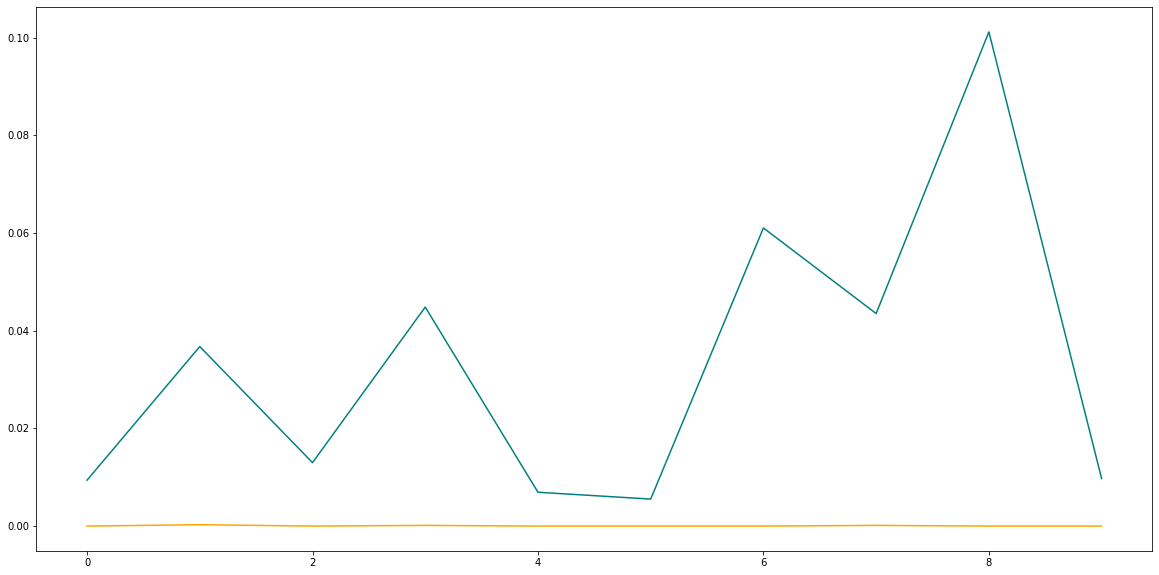

In [125]:
trg_acc = []
val_acc = []

for keys, values in results.items():

    acc_avg = sum(results[keys]['accuracy'])/len(results[keys]['accuracy'])
    val_acc_avg = sum(results[keys]['val_accuracy'])/len(results[keys]['val_accuracy'])
    trg_acc.append(acc_avg)
    val_acc.append(val_acc_avg)

plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))

plt.plot(trg_acc, color='teal', label='trg_acc')
plt.plot(val_acc, color='orange', label='val_acc')

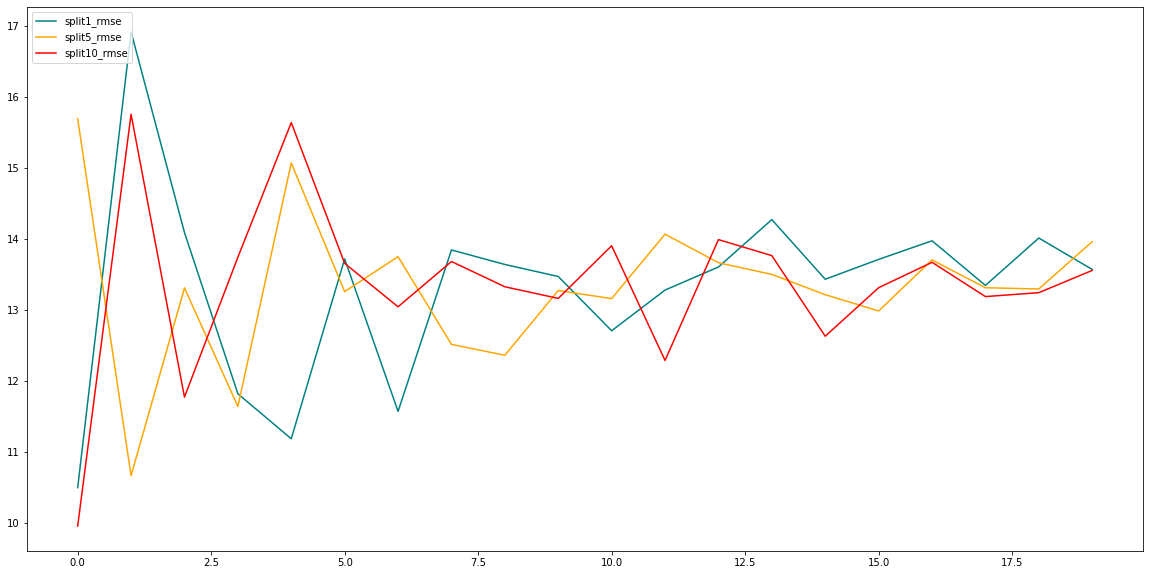

In [126]:
plt.plot(results['split_1']['rmse'], color='teal', label='split1_rmse')
plt.plot(results['split_5']['rmse'], color='orange', label='split5_rmse')
plt.plot(results['split_10']['rmse'], color='red', label='split10_rmse')
plt.legend(loc='upper left')
plt.show()

### Observation
Even with K Fold cross validation, not able to correct problem of overfitting in dataset.
Solution: Need more training samples per RP

## 9.2 Diagnosis Method 1
### Clustering of data points (Reduce no. of classes while increasing no. of samples per class)

Same idea as above but since now each RP has matrix from 4 UE, compare image similarity from each of the 4 UE and only consider images to be similar enough iF average of SSIM values >= 0.40

In [56]:
# may delete later
# New way to import the data
import h5py
import numpy as np
import tensorflow as tf

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
features_transposed = np.zeros((3876,193,16,4), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
print(features.shape)
print(features_transposed.shape)
print(labels.shape)

(3876, 4, 16, 193)
(3876, 193, 16, 4)
(3876,)


In [57]:
# Function to get euclidean distance
def get_euclidean_distance(base_point, cur_point):
    
    x_error = (base_point[0] - cur_point[0])**2
    y_error = (base_point[1] - cur_point[1])**2
    z_error = (base_point[2] - cur_point[2])**2

    return np.sqrt(x_error + y_error + z_error)

'''
def ssim_generate_heatmap(feature):

    im = plt.imshow(feature)
    plt.close() # for preventing heatmap from showing
    plt.clf() # clear current figure when done

    colour_vals_rgba = im.cmap(im.norm(im.get_array()))
    return tf.convert_to_tensor(colour_vals_rgba)
'''

In [75]:
import matplotlib.pyplot as plt

# allocated_rps keep track of rps that have been allocated a class based on distance and ssmi threshold to prevent one rp from having >1 class
allocated_rps = {}
visited = [0 for i in range(len(rp_dict))]

# Define thresholds
dist_threshold = 4
ssim_threshold = 0.5

# Iterate through each RP
for i, (key_1, value_1) in enumerate(rp_dict.items()):
    
    if visited[key_1] == 1:
        continue
        
    base_coords = value_1
    clustered_rps = []
    
    for j, (key_2, value_2) in enumerate(rp_dict.items()):
        
        # If RP has been visited before, skip iteration
        if visited[key_2] == 1:
            continue
            
        # Calculate distance from outer iteration point
        cur_coords = value_2
        frombase_dist = get_euclidean_distance(base_coords, cur_coords)
        
        # if distance < threshold and RP has not been clustered with another RP yet,
        if frombase_dist < dist_threshold and visited[key_2] != 1:
            
            ssim_value = tf.image.ssim(features_transposed[key_1], features_transposed[key_2], max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03).numpy()                

            if ssim_value >= ssim_threshold:
                clustered_rps.append(key_2)
                visited[key_2] = 1

    allocated_rps[key_1] = clustered_rps
    visited[key_1] = 1

In [76]:
# Confirm if no RP are clustered under more than 1 class
# By design of above algorithm, since each RP is only expanded upon if it is not visited yet, visited RPs will never appear in the values of any key.
# However, possible that RP clustered under one RP (in values) can also be a cluster(key) itself.

count = 0
for i, (key,value) in enumerate(allocated_rps.items()):
    
    count += 1
    for rp in value:
        if rp != key and rp in allocated_rps.keys():
            print(f'Error found: {key} and {rp}')
    
    count += (len(value) - 1)

print(count)
# No errors detected

3876


In [77]:
# Observe how many classes dataset has been reduced to and how many RPs on average clustered per RP

'''
For analytical purposes, want to get soemthing like:

0: [0, 1, 35, 1938, 1939, 1972, 1973]
1: [2, 36, 1940, 1974] 
.
.
.

'''

count = 0

for i, (key, value) in enumerate(allocated_rps.items()):
    count += len(value)

print(f'No. of classes after clustering: {len(allocated_rps)}')
print(f'Average no. of RP clustered per RP: {count/len(allocated_rps)}')

No. of classes after clustering: 2151
Average no. of RP clustered per RP: 1.801952580195258


In [78]:
# Now, let's update the labels and run our ML model on it
# features - using the same feature values from first UE, under variable first_ue_features
# labels - using the clustered labels

# Create dictionary so that each class has a set of coordinates to refer back to
# feature_0 --> xxx
# feature_3875 --> xxx
# ...
# feature_293 --> xxx
clusteredrp_dict = {}
for i, (key,value) in enumerate(allocated_rps.items()):
    for rp in value:
        clusteredrp_dict[rp] = key

# Sort the dictionary by key values so that
# feature_0 --> xxx
# feature_2 --> xxx
# ...
# feature_3875 --> xxx
sorted_clusteredrp_dict = {}
for i in range(len(rp_dict)):
    sorted_clusteredrp_dict[i] = clusteredrp_dict[i]

# print(sorted_clusteredrp_dict)
# Create a label vector that contains the class for each of the feature image
labels = list(sorted_clusteredrp_dict.values())
labels = np.array(labels)

# Prepare features for dataset
features_transposed = np.zeros((3876,193,16,4), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i].T

print(features.shape)
print(labels.shape)
print(features_transposed.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_transposed, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

# print(dataset)

(3876, 4, 16, 193)
(3876,)
(3876, 193, 16, 4)


In [79]:
# Numeric argument refers to size of buffer used in shuffling. Larger buffer size results in more thorough shuffling but requires more memory
dataset = dataset.shuffle(1000)
# reshuffle_each_iteration = False

In [80]:
# 3. Split the dataset into train, test and validaiton set
def split_dataset(ds):
    size = len(ds)
    train_size = int(round(size*0.7))
    val_size = int(round(size*0.2))
    test_size = int(round(size*0.1))
          
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [81]:
# 5. Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i][0]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        # print(f'RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [82]:
# What we have so far
from sklearn.model_selection import KFold

# print(features_transposed.shape)
# print(labels.shape)

# Get the images and labels for train and validation test set
train_features = np.array(list(train_dataset.map(lambda x,y : x)))
train_labels = np.array(list(train_dataset.map(lambda x,y : y)))

val_features = np.array(list(val_dataset.map(lambda x,y : x)))
val_labels = np.array(list(val_dataset.map(lambda x,y : y)))

# Split the data using K Fold algorithm
inputs = np.concatenate((train_features, val_features), axis = 0)
targets = np.concatenate((train_labels, val_labels), axis = 0)
kfold = KFold(n_splits = 10, shuffle = True)

# For each of the train, test
split_no = 1
results = {}

for train, val in kfold.split(inputs, targets):
    
    # Make model
    print(f'Processing split {split_no}')
    
    split_results = {}
    model_inputs = keras.Input(shape = (193, 16, 4))
    model_outputs = resnet18(model_inputs, num_classes = 3876)
    resnet18_model = keras.Model(model_inputs, model_outputs)
    
    # Compile model - Classification
    resnet18_model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])
    
    # Get the metrics
    val_callback = ValidationCallback(inputs[val], targets[val])
    hist = resnet18_model.fit(inputs[train], targets[train], batch_size = 32, callbacks = [val_callback], epochs = 20)
    split_results['loss'] = hist.history['loss']
    split_results['accuracy'] = hist.history['accuracy']
    split_results['val_loss'] = hist.history['val_loss']
    split_results['val_accuracy'] = hist.history['val_accuracy']
    split_results['rmse'] = hist.history['rmse']
    
    cur_split = 'split_' + str(split_no)
    results[cur_split] = split_results

    split_no += 1

print('All splits processed.')

Processing split 1
Epoch 1/20
98/99 [============================>.] - ETA: 0s - loss: 8.8694 - accuracy: 9.5663e-04

Epoch End - Custom Validation Callback
99/99 [==============================] - 3s 19ms/step - loss: 8.8672 - accuracy: 9.5572e-04 - val_loss: 8.4956 - val_accuracy: 0.0000e+00 - rmse: 9.7216
Epoch 2/20
96/99 [============================>.] - ETA: 0s - loss: 7.6485 - accuracy: 6.5104e-04

Epoch End - Custom Validation Callback
99/99 [==============================] - 1s 13ms/step - loss: 7.6539 - accuracy: 6.3715e-04 - val_loss: 8.2467 - val_accuracy: 0.0000e+00 - rmse: 12.2258
Epoch 3/20
96/99 [============================>.] - ETA: 0s - loss: 7.6323 - accuracy: 0.0013

Epoch End - Custom Validation Callback
99/99 [==============================] - 1s 13ms/step - loss: 7.6285 - accuracy: 0.0013 - val_loss: 8.8137 - val_accuracy: 0.0029 - rmse: 13.0320
Epoch 4/20
96/99 [============================>.] - ETA: 0s - loss: 7.4918 - accuracy: 0.0029

Epoch End - Custom Vali

In [83]:
allocated_rps

{0: [0, 2, 1939, 2010, 2109],
 1: [1, 3, 39, 1938, 1940, 2046],
 4: [4, 1943],
 5: [5, 7, 1944],
 6: [6, 8, 110, 146, 173, 1945, 1976],
 9: [9, 147, 1946, 1948, 2014, 2111],
 10: [10, 1949, 2152],
 11: [11, 45, 1947, 1950],
 12: [12, 148, 1951],
 13: [13, 1952],
 14: [14, 17, 1953, 1982, 2094],
 15: [15, 18, 184, 1954, 1957, 2018, 2095],
 16: [16, 19, 20, 150, 1955, 2017, 2061],
 21: [21, 22, 52, 1956, 2096],
 23: [23, 24],
 25: [25],
 26: [26, 27],
 28: [28, 29, 31, 62, 1968, 1999, 2000],
 30: [30, 32, 33, 168, 200, 201, 233, 1969, 1970, 1971, 2100],
 34: [34, 35, 1972],
 36: [36, 73, 1974, 2043, 2044, 2179],
 37: [37, 136, 1975],
 38: [38],
 40: [40, 1942, 1978, 2047, 2145, 2185],
 41: [41, 215, 1941, 1979, 2220],
 42: [42, 250, 1980, 2181],
 43: [43, 79, 1981, 2048],
 44: [44],
 46: [46, 48, 1984, 1985, 2187],
 47: [47, 49, 82, 252, 1986, 1987, 2050, 2051, 2222],
 50: [50, 1988],
 51: [51, 53, 1989],
 54: [54, 1959, 1960],
 55: [55, 1961, 1993, 2055, 2130],
 56: [56, 87, 1962, 1994]

<Figure size 1440x720 with 0 Axes>

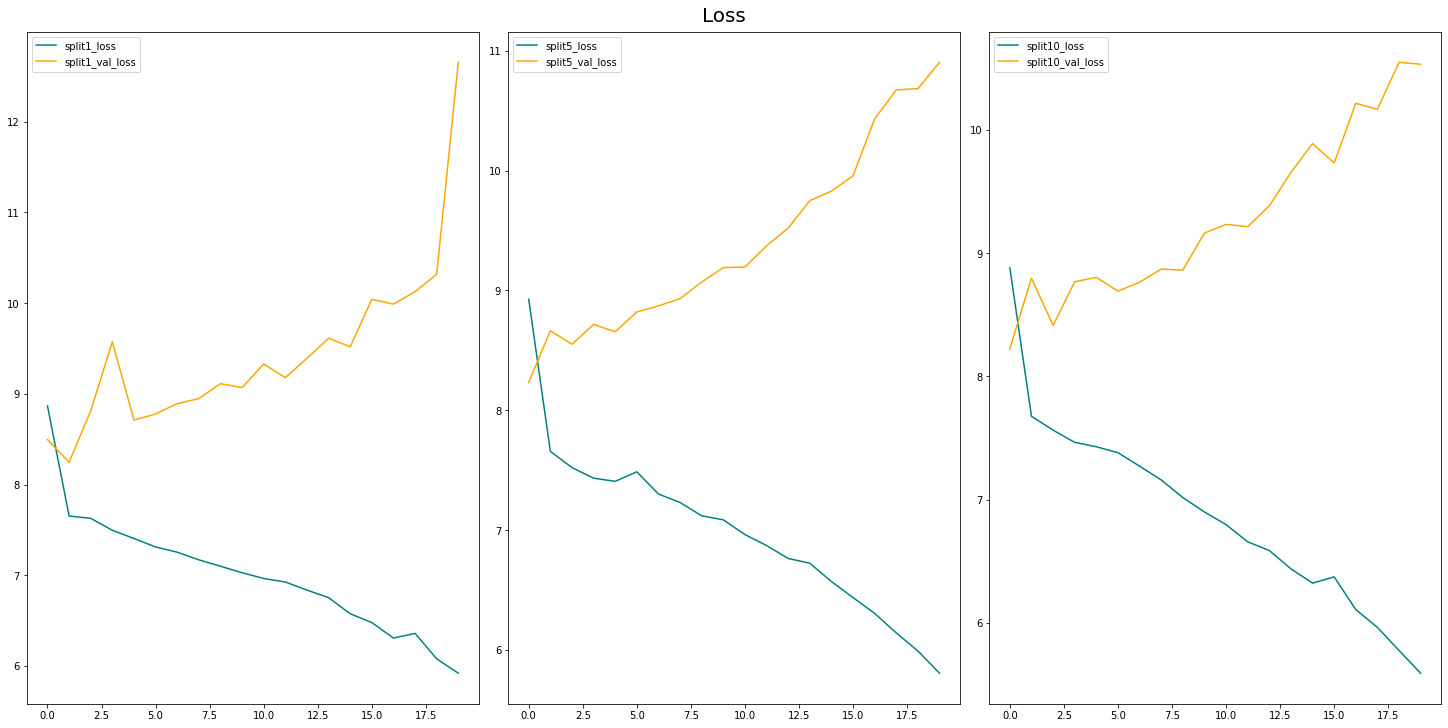

In [84]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['loss'], color='teal', label='split1_loss')
axs[0].plot(results['split_1']['val_loss'], color='orange', label='split1_val_loss')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_5']['loss'], color='teal', label='split5_loss')
axs[1].plot(results['split_5']['val_loss'], color='orange', label='split5_val_loss')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_10']['loss'], color='teal', label='split10_loss')
axs[2].plot(results['split_10']['val_loss'], color='orange', label='split10_val_loss')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

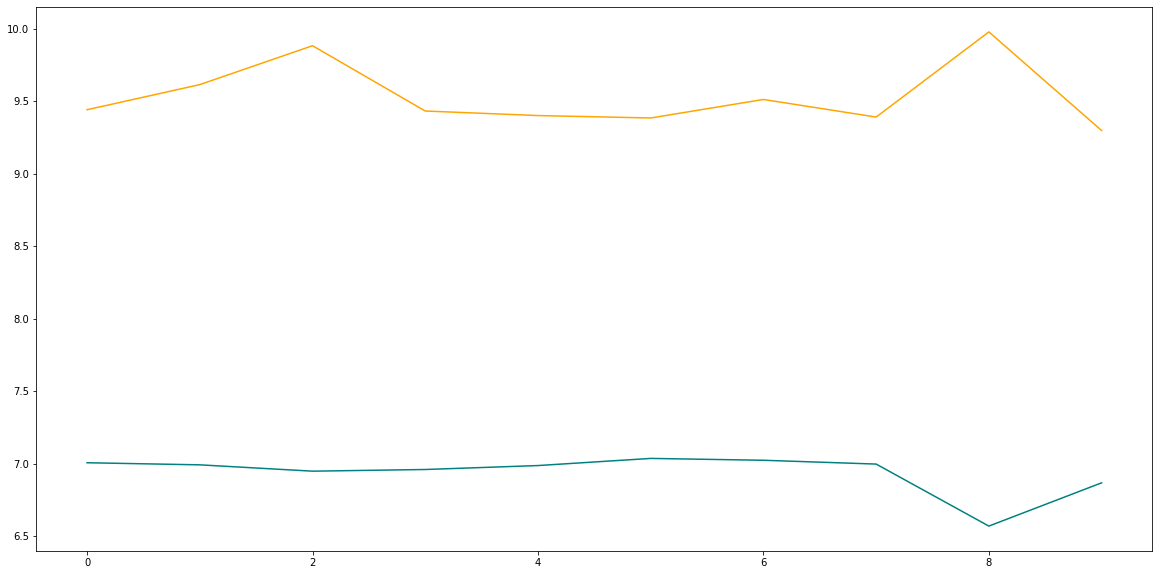

In [89]:
trg_loss = []
val_loss = []

for keys, values in results.items():

    trg_loss_avg = sum(results[keys]['loss'])/len(results[keys]['loss'])
    val_loss_avg = sum(results[keys]['val_loss'])/len(results[keys]['val_loss'])
    trg_loss.append(trg_loss_avg)
    val_loss.append(val_loss_avg)

plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))

plt.plot(trg_loss, color='teal', label='trg_loss')
plt.plot(val_loss, color='orange', label='val_loss')

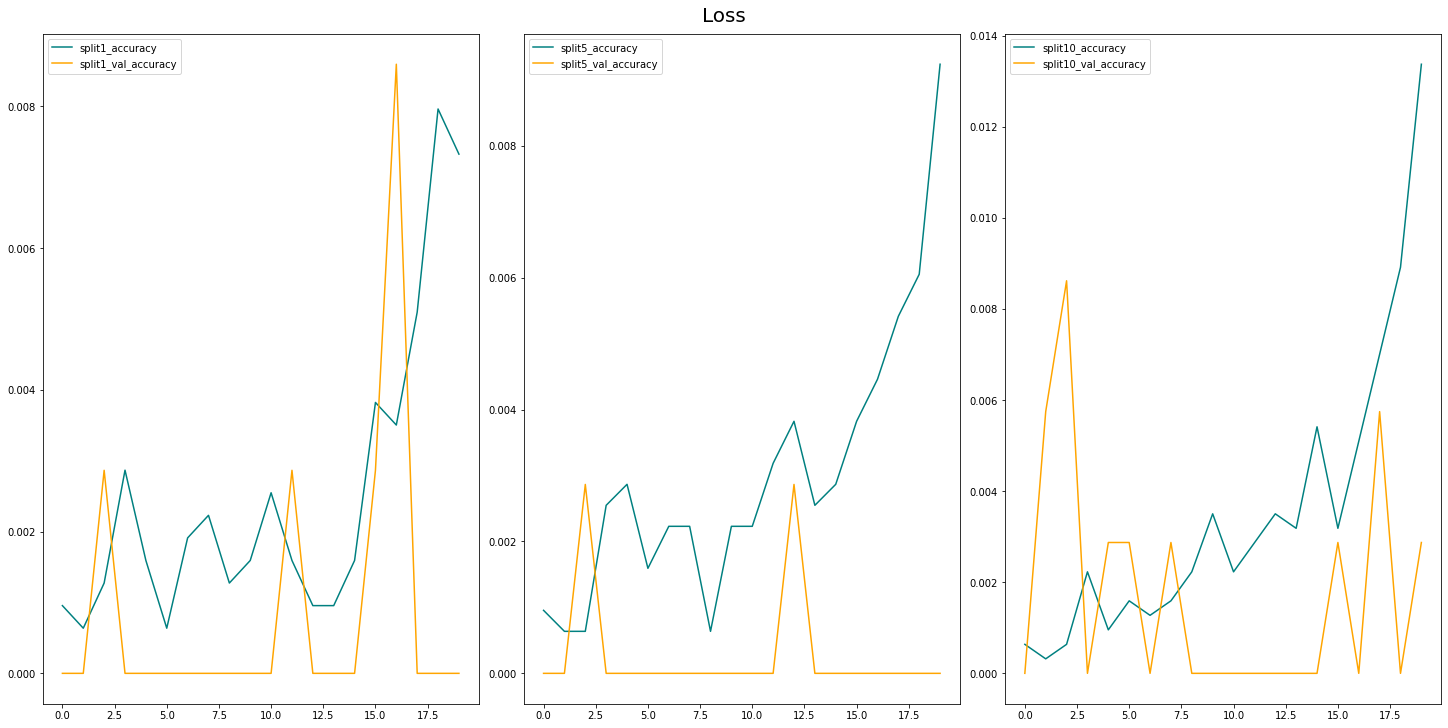

In [90]:
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['accuracy'], color='teal', label='split1_accuracy')
axs[0].plot(results['split_1']['val_accuracy'], color='orange', label='split1_val_accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_5']['accuracy'], color='teal', label='split5_accuracy')
axs[1].plot(results['split_5']['val_accuracy'], color='orange', label='split5_val_accuracy')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_10']['accuracy'], color='teal', label='split10_accuracy')
axs[2].plot(results['split_10']['val_accuracy'], color='orange', label='split10_val_accuracy')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

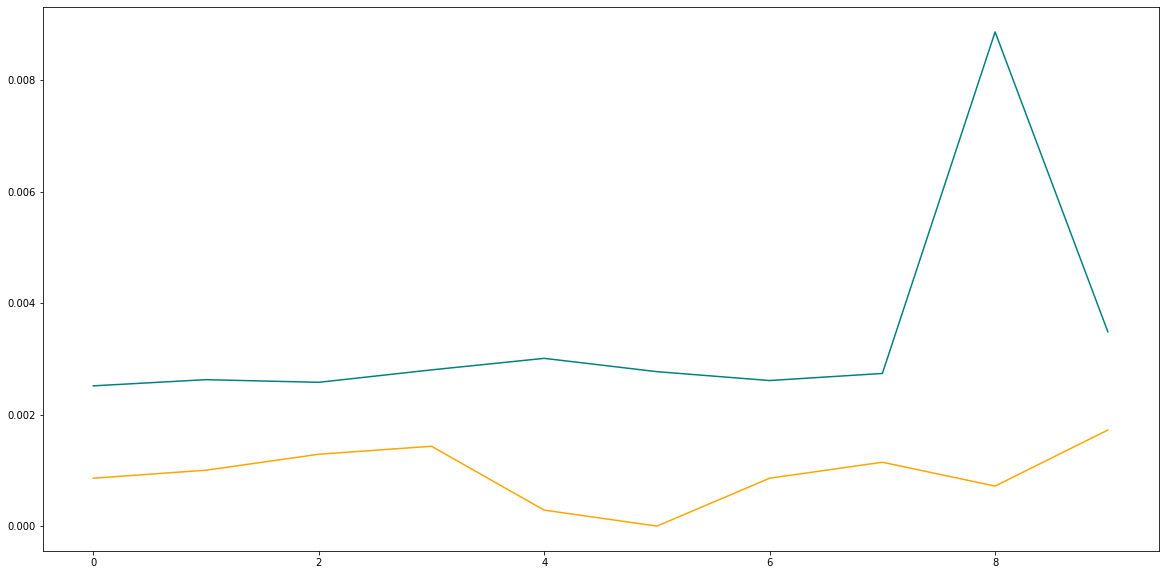

In [92]:
trg_acc = []
val_acc = []

for keys, values in results.items():

    acc_avg = sum(results[keys]['accuracy'])/len(results[keys]['accuracy'])
    val_acc_avg = sum(results[keys]['val_accuracy'])/len(results[keys]['val_accuracy'])
    trg_acc.append(acc_avg)
    val_acc.append(val_acc_avg)

plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))

plt.plot(trg_acc, color='teal', label='trg_acc')
plt.plot(val_acc, color='orange', label='val_acc')

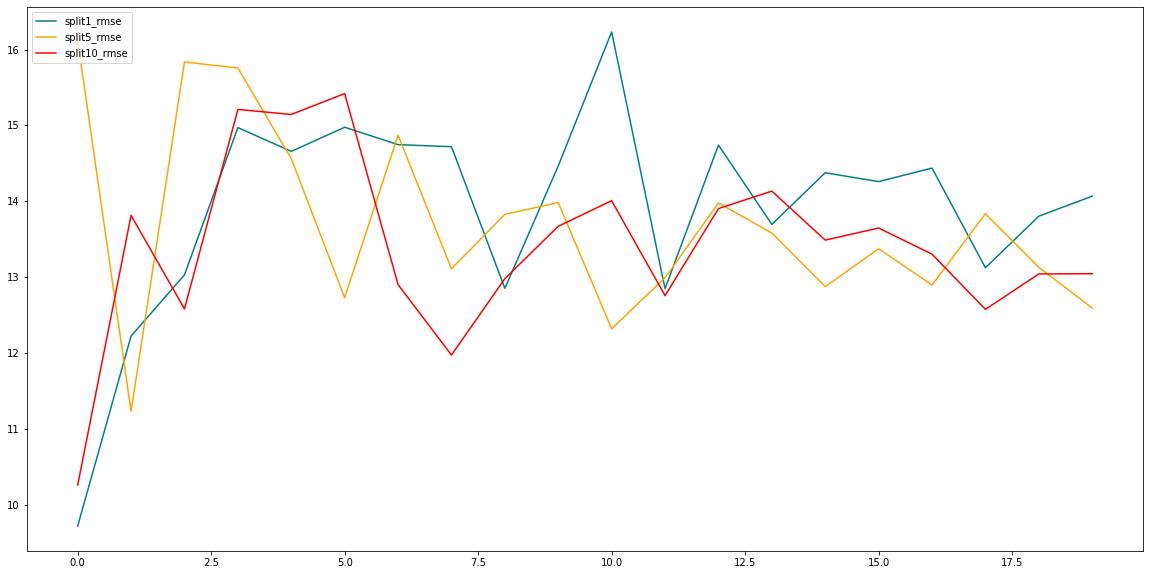

In [93]:
plt.plot(results['split_1']['rmse'], color='teal', label='split1_rmse')
plt.plot(results['split_5']['rmse'], color='orange', label='split5_rmse')
plt.plot(results['split_10']['rmse'], color='red', label='split10_rmse')
plt.legend(loc='upper left')
plt.show()

## 9.3 Diagnosis Method 4
### Data Augmentation - Adding noise to data

In this diagnostic method, we will combine datasets at different noise levels and perform K Fold cross validation to see if overfitting is reduced.

In [138]:
rp_dict = {}
    
def generate_dataset(filename):
        
    hdf5_file = h5py.File(filename, 'r')

    features_dataset = hdf5_file['features']
    labels_dataset = hdf5_file['labels']['position']

    # Convert HDF5 dataset to NumPy array
    features = np.array(features_dataset)
    labels = np.array(labels_dataset)

    # Prepare features for dataset
    # Retrieve features from the first UE and transpose the individual matrix
    features_transposed = np.zeros((3876,193,16,4), dtype = np.float64)
    for i in range(len(features)):
        features_transposed[i] = features[i].T

    # Prepare labels for dataset
    count = 0
    # For labels, have a shape of (1,) where that number represents the class of that coordinate

    for label in labels:
        rp_dict[count] = label
        count += 1
    
    labels = np.array([i for i in range(3876)])

    # Close the HDF5 file
    hdf5_file.close()

    dataset = tf.data.Dataset.from_tensor_slices((features_transposed, labels))
    dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))
    
    return dataset

snr10_ds = generate_dataset('dataset_SNR10_outdoor.mat')
snr20_ds = generate_dataset('dataset_SNR20_outdoor.mat')
snr50_ds = generate_dataset('dataset_SNR50_outdoor.mat')

dataset = snr10_ds.concatenate(snr20_ds)
dataset = dataset.concatenate(snr50_ds)

print(dataset)

(3876, 193, 16, 4)
(3876,)
(3876, 193, 16, 4)
(3876,)
(3876, 193, 16, 4)
(3876,)
<ConcatenateDataset element_spec=(TensorSpec(shape=(193, 16, 4), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [141]:
# Numeric argument refers to size of buffer used in shuffling. Larger buffer size results in more thorough shuffling but requires more memory
dataset = dataset.shuffle(1000)
# reshuffle_each_iteration = False

In [142]:
# Split the dataset into train, test and validaiton set
def split_dataset(ds):
    size = len(ds)
    train_size = int(round(size*0.7))
    val_size = int(round(size*0.2))
    test_size = int(round(size*0.1))
          
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [150]:
# What we have so far
from sklearn.model_selection import KFold

# print(features_transposed.shape)
# print(labels.shape)

# Get the images and labels for train and validation test set
train_features = np.array(list(train_dataset.map(lambda x,y : x)))
train_labels = np.array(list(train_dataset.map(lambda x,y : y)))

val_features = np.array(list(val_dataset.map(lambda x,y : x)))
val_labels = np.array(list(val_dataset.map(lambda x,y : y)))

# Split the data using K Fold algorithm
inputs = np.concatenate((train_features, val_features), axis = 0)
targets = np.concatenate((train_labels, val_labels), axis = 0)
kfold = KFold(n_splits = 10, shuffle = True)

# For each of the train, test
split_no = 1
results = {}

for train, val in kfold.split(inputs, targets):
    
    # Make model
    print(f'Processing split {split_no}')
    
    split_results = {}
    model_inputs = keras.Input(shape = (193, 16, 4))
    model_outputs = resnet18(model_inputs, num_classes = 3876)
    resnet18_model = keras.Model(model_inputs, model_outputs)
    
    # Compile model - Classification
    resnet18_model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])
    
    # Get the metrics
    val_callback = ValidationCallback(inputs[val], targets[val])
    hist = resnet18_model.fit(inputs[train], targets[train], batch_size = 32, callbacks = [val_callback], epochs = 20)
    split_results['loss'] = hist.history['loss']
    split_results['accuracy'] = hist.history['accuracy']
    split_results['val_loss'] = hist.history['val_loss']
    split_results['val_accuracy'] = hist.history['val_accuracy']
    split_results['rmse'] = hist.history['rmse']
    
    cur_split = 'split_' + str(split_no)
    results[cur_split] = split_results

    split_no += 1

print('All splits processed.')

Processing split 1
Epoch 1/20
295/295 [==============================] - ETA: 0s - loss: 8.5558 - accuracy: 2.1234e-04

Epoch End - Custom Validation Callback
295/295 [==============================] - 6s 14ms/step - loss: 8.5558 - accuracy: 2.1234e-04 - val_loss: 8.3411 - val_accuracy: 9.5511e-04 - rmse: 15.0631
Epoch 2/20
293/295 [============================>.] - ETA: 0s - loss: 8.2733 - accuracy: 0.0000e+00

Epoch End - Custom Validation Callback
295/295 [==============================] - 4s 13ms/step - loss: 8.2734 - accuracy: 0.0000e+00 - val_loss: 8.3933 - val_accuracy: 9.5511e-04 - rmse: 12.9711
Epoch 3/20
291/295 [============================>.] - ETA: 0s - loss: 8.2346 - accuracy: 2.1478e-04

Epoch End - Custom Validation Callback
295/295 [==============================] - 4s 13ms/step - loss: 8.2342 - accuracy: 2.1234e-04 - val_loss: 8.5122 - val_accuracy: 0.0000e+00 - rmse: 11.6317
Epoch 4/20
295/295 [==============================] - ETA: 0s - loss: 8.1761 - accuracy: 5.30

<Figure size 1440x720 with 0 Axes>

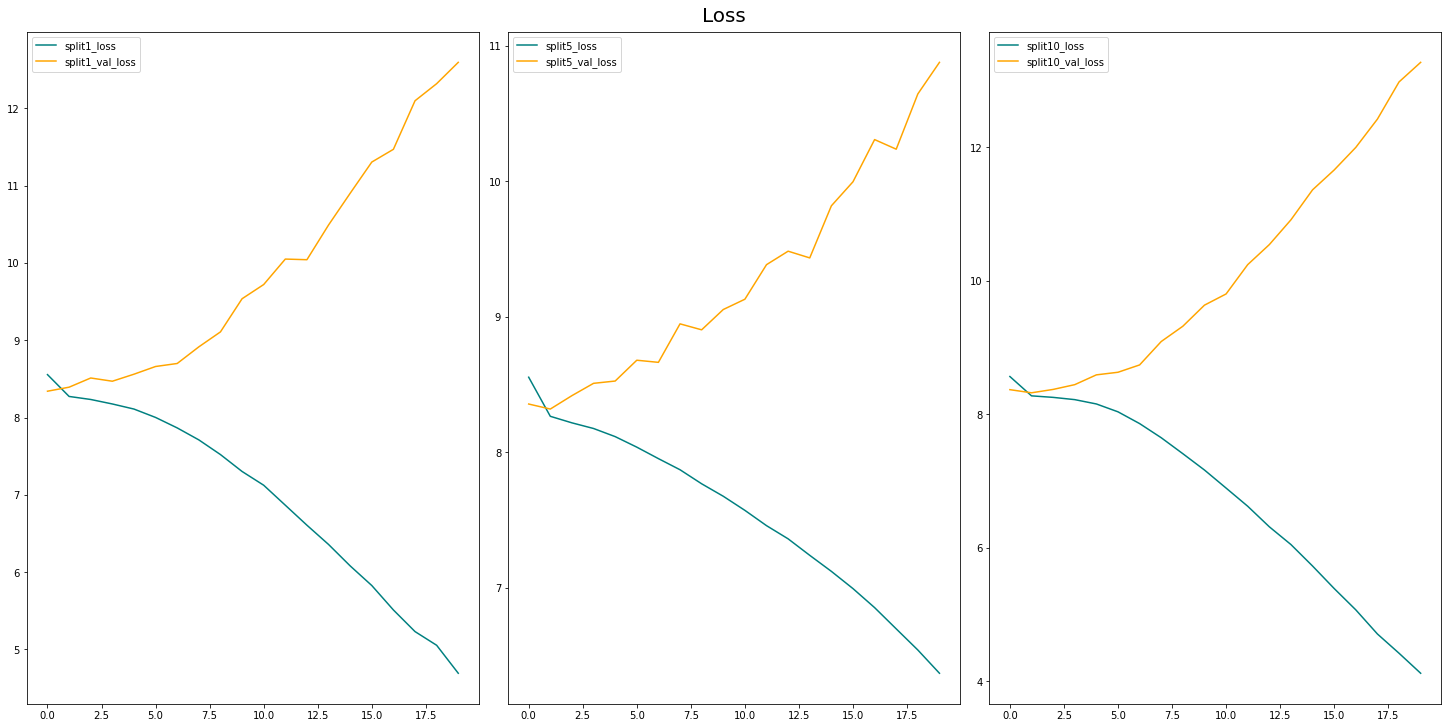

In [151]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['loss'], color='teal', label='split1_loss')
axs[0].plot(results['split_1']['val_loss'], color='orange', label='split1_val_loss')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_5']['loss'], color='teal', label='split5_loss')
axs[1].plot(results['split_5']['val_loss'], color='orange', label='split5_val_loss')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_10']['loss'], color='teal', label='split10_loss')
axs[2].plot(results['split_10']['val_loss'], color='orange', label='split10_val_loss')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

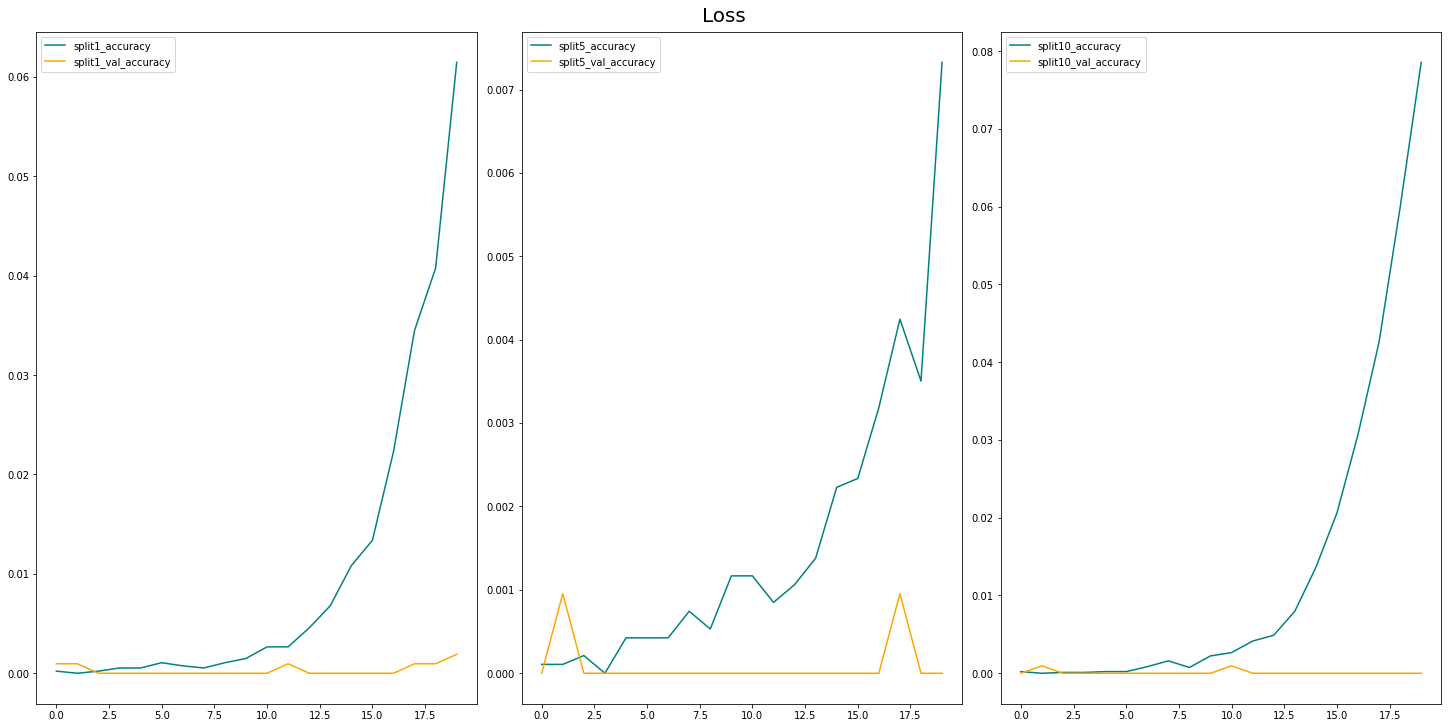

In [153]:
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['accuracy'], color='teal', label='split1_accuracy')
axs[0].plot(results['split_1']['val_accuracy'], color='orange', label='split1_val_accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_5']['accuracy'], color='teal', label='split5_accuracy')
axs[1].plot(results['split_5']['val_accuracy'], color='orange', label='split5_val_accuracy')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_10']['accuracy'], color='teal', label='split10_accuracy')
axs[2].plot(results['split_10']['val_accuracy'], color='orange', label='split10_val_accuracy')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

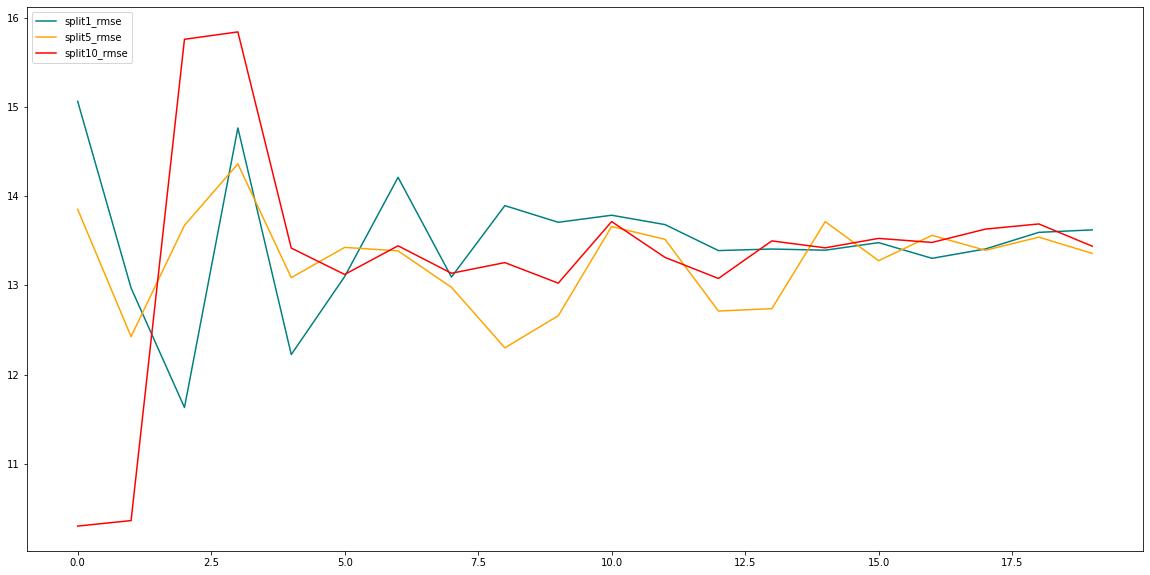

In [154]:
plt.plot(results['split_1']['rmse'], color='teal', label='split1_rmse')
plt.plot(results['split_5']['rmse'], color='orange', label='split5_rmse')
plt.plot(results['split_10']['rmse'], color='red', label='split10_rmse')
plt.legend(loc='upper left')
plt.show()

## 9.3 Diagnosis Method 4
### Data Augmentation - Resizing, Rescaling and Random Rotations
(Random Flipping may not work here to preserve order of MIMO channels)

In [243]:
rp_dict = {}
    
    
def generate_dataset(filename):
        
    hdf5_file = h5py.File(filename, 'r')

    features_dataset = hdf5_file['features']
    labels_dataset = hdf5_file['labels']['position']

    # Convert HDF5 dataset to NumPy array
    features = np.array(features_dataset)
    labels = np.array(labels_dataset)

    # Prepare features for dataset
    # Retrieve features from the first UE and transpose the individual matrix
    features_transposed = np.zeros((3876,193,16,4), dtype = np.float64)
    for i in range(len(features)):
        features_transposed[i] = features[i].T

    # Prepare labels for dataset
    count = 0
    # For labels, have a shape of (1,) where that number represents the class of that coordinate

    for label in labels:
        rp_dict[count] = label
        count += 1
    
    labels = np.array([i for i in range(3876)])

    # Close the HDF5 file
    hdf5_file.close()

    dataset = tf.data.Dataset.from_tensor_slices((features_transposed, labels))
    dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))
    
    return dataset

snr10_ds = generate_dataset('dataset_SNR10_outdoor.mat')
snr20_ds = generate_dataset('dataset_SNR20_outdoor.mat')
snr50_ds = generate_dataset('dataset_SNR50_outdoor.mat')

dataset = snr10_ds.concatenate(snr20_ds)
dataset = dataset.concatenate(snr50_ds)

print(dataset)

<ConcatenateDataset element_spec=(TensorSpec(shape=(193, 16, 4), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


(386, 16, 4)
386


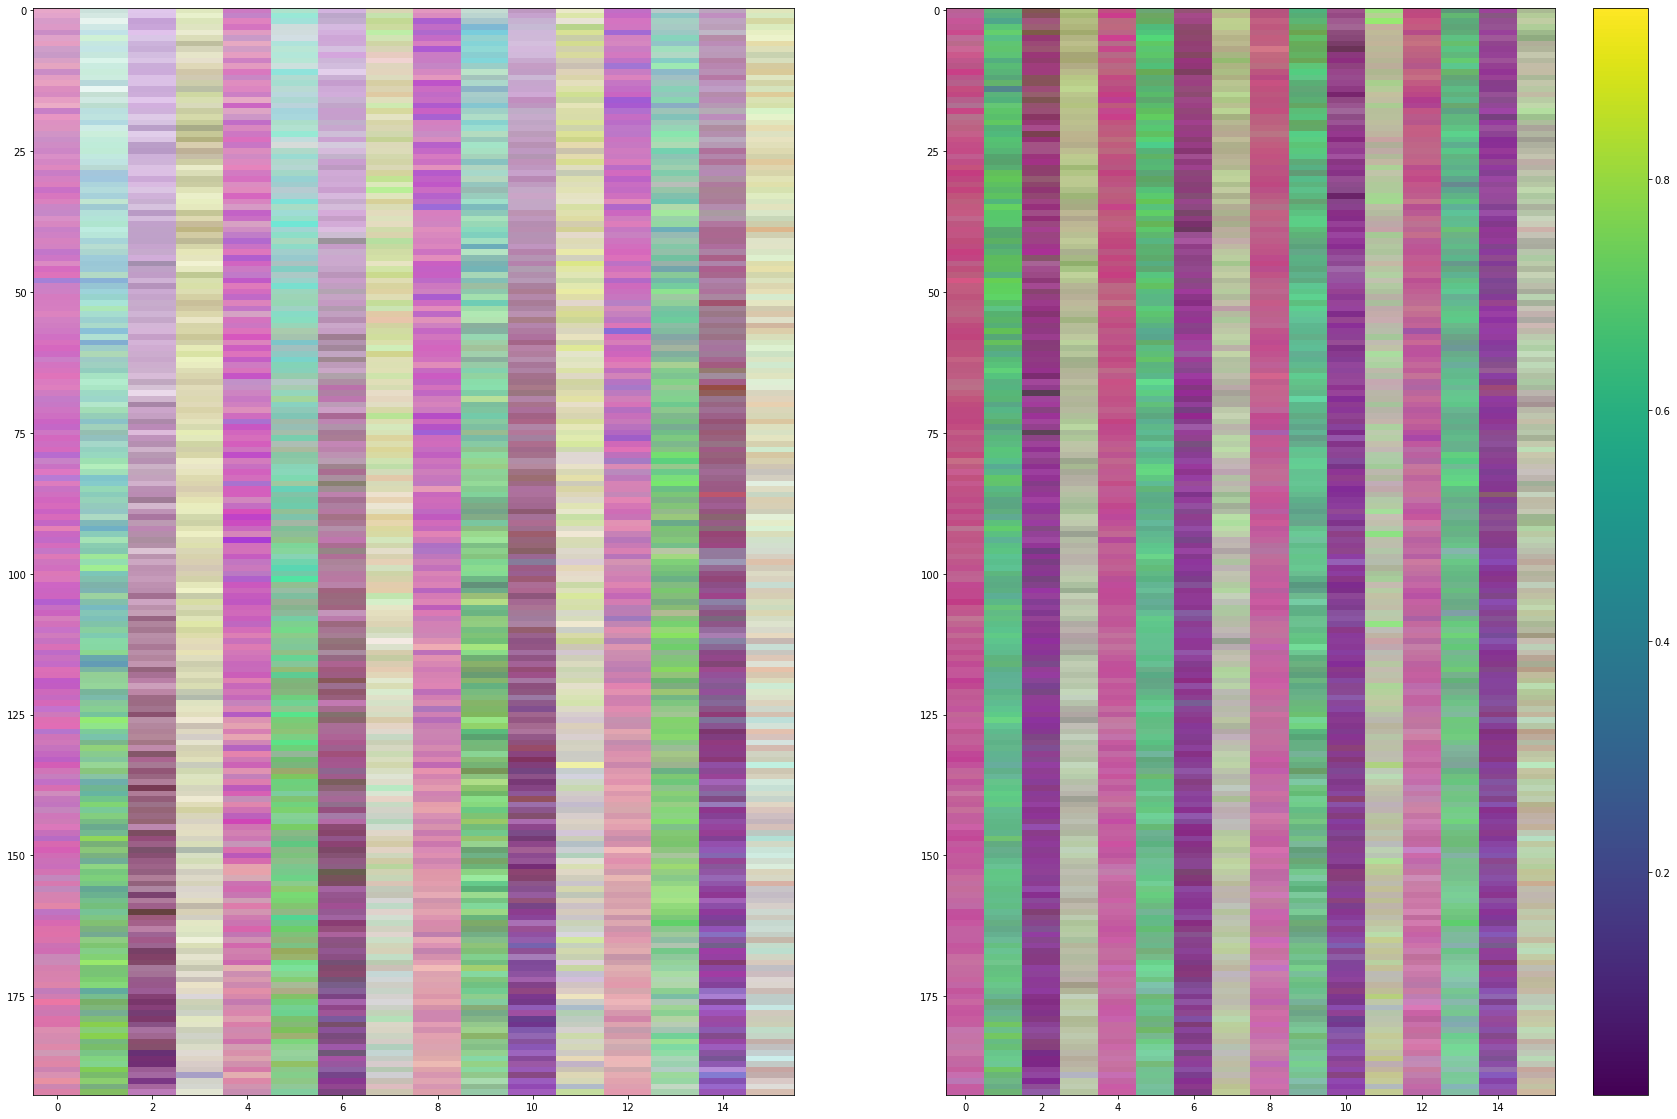

In [254]:
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
# Rescaling pixels not applicable since pixel values are already in range of [0,1]
# Flipping image not applicable since this may change original order of UE channels
# tf.keras.layers.Resizing(height, width, ...)

# Considered: Flipping, Rotation, Resizing and Contrast
# Chosen: Rotation, Contrast

# Function to generate heatmaps, not the same as function below used to get heatmap pixel values from heatmap
def get_features(feature):
    
    for f, l in feature:
        
        f = f.numpy()
        # f = f.T
        return f
    
sample_img_1 = get_features(dataset.take(1))
sample_img_2 = get_features(dataset.skip(1).take(1))
plt.rcParams['figure.figsize'] = [30, 20]

sample_imgs = np.concatenate((sample_img_1, sample_img_2), axis = 0)
print(sample_imgs.shape)

fig, axs = plt.subplots(1,2)
plt.colorbar(plt.imshow(sample_img_1))
axs[0].imshow(sample_img_1, aspect = 'auto')
axs[1].imshow(sample_img_2, aspect = 'auto')

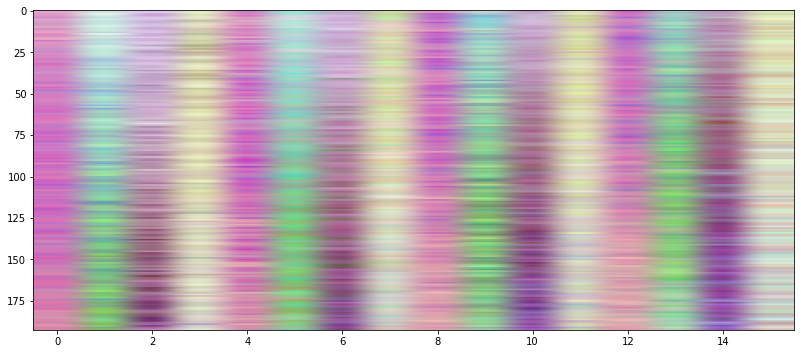

In [256]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(sample_img, 2), tf.float32)
import random

for i in range(1):
    rand = random.uniform(0.1, 0.5)
    data_augmentation = tf.keras.Sequential([layers.RandomRotation(factor=rand)])
    augmented_image = data_augmentation(sample_img_1)
    sample_img = augmented_image
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(augmented_image, aspect = 'auto')
    # plt.axis("off")